In [1]:
!pip install catboost
!pip install eli5
!pip install xgboost
!pip install hyperopt

# Import Packages

In [2]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
from collections import OrderedDict
%matplotlib inline

# Checking Leverage and Influence Points
from statsmodels.graphics.regressionplots import *
import statsmodels.stats.stattools as stools
import statsmodels.formula.api as smf
import statsmodels.stats as stats
import scipy.stats as scipystats
import statsmodels.api as sm

# Checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Cluster analysis
from sklearn.cluster import KMeans

# Feature importance
import eli5
from eli5.sklearn import PermutationImportance

# Modelling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR
import xgboost as xgb

# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Hyperparameter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.utils import resample

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 2020
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

C:\Users\ARUL TRADERS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\ARUL TRADERS\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read the dataset and display first five rows

In [3]:
# Reading the data as dataframe and print the first five rows
concrete = pd.read_csv('concrete.csv')
concrete.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg  age  \
0  141.30 212.00   0.00 203.50          0.00     971.80   748.50   28   
1  168.90  42.20 124.30 158.30         10.80    1080.80   796.20   14   
2  250.00   0.00  95.70 187.40          5.50     956.90   861.20   28   
3  266.00 114.00   0.00 228.00          0.00     932.00   670.00   28   
4  154.80 183.40   0.00 193.30          9.10    1047.40   696.70   28   

   strength  
0     29.89  
1     23.51  
2     29.22  
3     45.85  
4     18.29

# 1) Exploratory Data Analysis

In [4]:
#Performing exploratory data analysis on the cement dataset
print('Several Helper functions for EDA and Model building'); print('--'*50)

# Customized describe function
def custom_describe(df):
  results = []
  for col in df.select_dtypes(include = ['float64', 'int64']).columns.tolist():
    stats = OrderedDict({'': col, 'Count': df[col].count(), 'Type': df[col].dtype, 'Mean': round(df[col].mean(), 2), 'StandardDeviation': round(df[col].std(), 2), 
                         'Variance': round(df[col].var(), 2), 'Minimum': round(df[col].min(), 2), 'Q1': round(df[col].quantile(0.25), 2), 
                         'Median': round(df[col].median(), 2), 'Q3': round(df[col].quantile(0.75), 2), 'Maximum': round(df[col].max(), 2),
                         'Range': round(df[col].max(), 2)-round(df[col].min(), 2), 'IQR': round(df[col].quantile(0.75), 2)-round(df[col].quantile(0.25), 2),
                         'Kurtosis': round(df[col].kurt(), 2), 'Skewness': round(df[col].skew(), 2), 'MeanAbsoluteDeviation': round(df[col].mad(), 2)})
    if df[col].skew() < -1:
      if df[col].median() < df[col].mean():
        ske = 'Highly Skewed (Right)'
      else:
        ske = 'Highly Skewed (Left)'
    elif -1 <= df[col].skew() <= -0.5:
      if df[col].median() < df[col].mean():
        ske = 'Moderately Skewed (Right)'
      else:
        ske = 'Moderately Skewed (Left)'
    elif -0.5 < df[col].skew() <= 0:
      if df[col].median() < df[col].mean():
        ske = 'Fairly Symmetrical (Right)'
      else:
        ske = 'Fairly Symmetrical (Left)'
    elif 0 < df[col].skew() <= 0.5:
      if df[col].median() < df[col].mean():
        ske = 'Fairly Symmetrical (Right)'
      else:
        ske = 'Fairly Symmetrical (Left)'
    elif 0.5 < df[col].skew() <= 1:
      if df[col].median() < df[col].mean():
        ske = 'Moderately Skewed (Right)'
      else:
        ske = 'Moderately Skewed (Left)'
    elif df[col].skew() > 1:
      if df[col].median() < df[col].mean():
        ske = 'Highly Skewed (Right)'
      else:
        ske = 'Highly Skewed (Left)'
    else:
      ske = 'Error'
    stats['SkewnessComment'] = ske
    upper_lim, lower_lim = stats['Q3'] + (1.5 * stats['IQR']), stats['Q1'] - (1.5 * stats['IQR'])
    if len([x for x in df[col] if x < lower_lim or x > upper_lim])>1:
      out = 'HasOutliers'
    else:
      out = 'NoOutliers'
    stats['OutliersComment'] = out
    results.append(stats)
  statistics = pd.DataFrame(results).set_index('')

  return display(statistics)

# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm, rug = True).set_title(f'{col} with outliers')
    ax2.axvline(df[col].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth = 1.2)
    ax2.axvline(df[col].median(), color = 'g', linestyle = '--', label = 'Median', linewidth = 1.2)
    ax2.axvline(df[col].mode()[0], color = 'b', linestyle = '--', label = 'Mode', linewidth = 1.2); ax2.legend(loc = 'best')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm, rug = True).set_title(f'{col} without outliers')
    ax3.axvline(y[col].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth = 1.2)
    ax3.axvline(y[col].median(), color = 'g', linestyle = '--', label = 'Median', linewidth = 1.2)
    ax3.axvline(y[col].mode()[0], color = 'b', linestyle = '--', label = 'Mode', linewidth = 1.2); ax3.legend(loc = 'best')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

# Correlation matrix for all variables
def correlation_matrix(df, threshold = 0.8):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 7.2))
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
    ax.set_title('Correlation Matrix of Data')

    # Filter for correlation value greater than threshold
    sort = corr.abs().unstack()
    sort = sort.sort_values(kind = "quicksort", ascending = False)
    display(sort[(sort > threshold) & (sort < 1)])
    
# Outliers removal
def outliers(df, col, method = 'quantile', strategy = 'median', drop = True):
    if method == 'quantile':
        Q3, Q2, Q1 = df[col].quantile([0.75, 0.50, 0.25])
        IQR = Q3 - Q1
        upper_lim = Q3 + (1.5 * IQR)
        lower_lim = Q1 - (1.5 * IQR)
        print(f'Outliers for {col} are: {sorted([x for x in df[col] if x < lower_lim or x > upper_lim])}\n')
        if strategy == 'median':
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = Q2
        else:
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = df[col].mean()
    elif method == 'stddev':
        col_mean, col_std, Q2 = df[col].mean(), df[col].std(), df[col].median()
        cut_off = col_std * 3
        lower_lim, upper_lim = col_mean - cut_off, col_mean + cut_off
        print(f'Outliers for {col} are: {sorted([x for x in df[col] if x < lower_lim or x > upper_lim])}\n')
        if strategy == 'median':
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = Q2
        else:
            df.loc[(df[col] < lower_lim) | (df[col] > upper_lim), col] = col_mean
    else:
      print('Please pass the correct method, strategy or drop criteria')

# KMeans Plots
def kmeans_plots(df, compcol):
  columns = list(set(list(df.columns))-set([compcol]))
  f, ax = plt.subplots(4, 2, figsize = (15, 15))
  ax[0][0].scatter(X[compcol], X[columns[0]], c = labels, s = 25, cmap = 'viridis'); ax[0][0].set_xlabel(compcol); ax[0][0].set_ylabel(columns[0])
  ax[0][1].scatter(X[compcol], X[columns[1]], c = labels, s = 25, cmap = 'viridis'); ax[0][1].set_xlabel(compcol); ax[0][1].set_ylabel(columns[1])
  ax[1][0].scatter(X[compcol], X[columns[2]], c = labels, s = 25, cmap = 'viridis'); ax[1][0].set_xlabel(compcol); ax[1][0].set_ylabel(columns[2])
  ax[1][1].scatter(X[compcol], X[columns[3]], c = labels, s = 25, cmap = 'viridis'); ax[1][1].set_xlabel(compcol); ax[1][1].set_ylabel(columns[3])
  ax[2][0].scatter(X[compcol], X[columns[4]], c = labels, s = 25, cmap = 'viridis'); ax[2][0].set_xlabel(compcol); ax[2][0].set_ylabel(columns[4])
  ax[2][1].scatter(X[compcol], X[columns[5]], c = labels, s = 25, cmap = 'viridis'); ax[2][1].set_xlabel(compcol); ax[2][1].set_ylabel(columns[5])
  ax[3][0].scatter(X[compcol], X[columns[6]], c = labels, s = 25, cmap = 'viridis'); ax[3][0].set_xlabel(compcol); ax[3][0].set_ylabel(columns[5])

# For rmse scoring
def rmse_score(y, y_pred):
    return np.sqrt(np.mean((y_pred - y)**2))

# Function to retrieve top results from grid search and randomized search
def report(results):
    df = pd.concat([pd.DataFrame(results.cv_results_['params']), pd.DataFrame(results.cv_results_['mean_test_score'], columns = ['r2'])], axis = 1)
    return df

Several Helper functions for EDA and Model building
----------------------------------------------------------------------------------------------------


# 1.a Univariate analysis

In [5]:
# Display Concrete Features
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [6]:
concrete.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64

In [7]:
concrete.shape

(1030, 9)

Dataset has 1030 rows and 9 columns, with no missing values.

All features are of numerical types. strength is a target variable (continuous). age is a discrete feature whereas rest of them are continuous.

In [8]:
#Display  Five point summary of numerical attributes and check unique values in 'object' columns
print('Five Point summary of the Concrete Dataframe'); print('--'*50)
custom_describe(concrete)

Five Point summary of the Concrete Dataframe
----------------------------------------------------------------------------------------------------


Count     Type   Mean  StandardDeviation  Variance  Minimum  \
                                                                            
cement         1030  float64 281.17             104.51  10921.58   102.00   
slag           1030  float64  73.90              86.28   7444.12     0.00   
ash            1030  float64  54.19              64.00   4095.62     0.00   
water          1030  float64 181.57              21.35    456.00   121.80   
superplastic   1030  float64   6.20               5.97     35.69     0.00   
coarseagg      1030  float64 972.92              77.75   6045.68   801.00   
fineagg        1030  float64 773.58              80.18   6428.19   594.00   
age            1030    int64  45.66              63.17   3990.44     1.00   
strength       1030  float64  35.82              16.71    279.08     2.33   

                 Q1  Median      Q3  Maximum  Range    IQR  Kurtosis  \
                                                                       
cement       192.38  272.90  350.00   540.00 438.00 157.62     -0.52   
slag           0.00   22.00  142.95   359.40 359.40 142.95     -0.51   
ash            0.00    0.00  118.30   200.10 200.10 118.30     -1.33   
water        164.90  185.00  192.00   247.00 125.20  27.10      0.12   
superplastic   0.00    6.40   10.20    32.20  32.20  10.20      1.41   
coarseagg    932.00  968.00 1029.40  1145.00 344.00  97.40     -0.60   
fineagg      730.95  779.50  824.00   992.60 398.60  93.05     -0.10   
age            7.00   28.00   56.00   365.00 364.00  49.00     12.17   
strength      23.71   34.45   46.14    82.60  80.27  22.43     -0.31   

              Skewness  MeanAbsoluteDeviation             SkewnessComment  \
                                                                            
cement            0.51                  86.78   Moderately Skewed (Right)   
slag              0.80                  76.93   Moderately Skewed (Right)   
ash               0.54                  60.42   Moderately Skewed (Right)   
water             0.07                  16.92   Fairly Symmetrical (Left)   
superplastic      0.91                   4.92    Moderately Skewed (Left)   
coarseagg        -0.04                  62.80  Fairly Symmetrical (Right)   
fineagg          -0.25                  61.88   Fairly Symmetrical (Left)   
age               3.27                  39.12       Highly Skewed (Right)   
strength          0.42                  13.46  Fairly Symmetrical (Right)   

             OutliersComment  
                              
cement            NoOutliers  
slag             HasOutliers  
ash               NoOutliers  
water            HasOutliers  
superplastic     HasOutliers  
coarseagg         NoOutliers  
fineagg          HasOutliers  
age              HasOutliers  
strength         HasOutliers

Observation 3 - Descriptive statistics

cement: Data ranges between 102 to 540, while 25th and 75th percentile is spread between 192.38 to 350. Median (272.90) is less than Mean (281.17) which means cement is moderately skewed to the right. Column has no outliers.
    
slag: Data ranges between 0 to 359.40, while 25th and 75th percentile is spread between 0 to 142.95. Median (22) is less than Mean (73.90) which means slag is moderately skewed to the right. Column has outliers.
    
ash: Data ranges between 0 to 200.10, while 25th and 75th percentile is spread between 0 to 118.30. Median (0) is less than Mean (54.19) which mean ash is moderately skewed to the right. Column has no outliers.
    
water: Data ranges between 121.80 to 247, while 25th and 75th percentile is spread between 164.90 and 192. Median (185) is greater than Mean (181.57) which means water is skewed to the left (fairly sym). Column has outliers.
    
superplastic: Data ranges between 0 to 32.20, while 25th and 75th percentile is spread between 0 to 10.20. Median (6.40) is greater than Mean (6.20) which means superplastic is moderately skewed to the left. Column has outliers.
    
coarseagg: Data ranges between 801 to 1145, while 25th and 75th percentile is spread between 932 to 1029.40. Median (968) is less than Mean (972.92) which means coarseagg is skewed to the right (fairly sym). Column has no outliers.
    
fineagg: Data ranges between 594 to 992.60, while 25th and 75th percentile is spread between 730.95 to 824. Median (779.5) is greater than Mean (773.58) which means fineagg is skewed to the left (fairly sym). Column has no outliers.
    
age: Data ranges between 1 to 365, while 25th and 75th percentile is spread between 7 to 56. Median (28) is less than Mean (45.66) which means age is highly skewed to the right. Column has no outliers.
    
strength: Data ranges between 2.33 to 82.60, while 25th and 75th percentile is spread between 23.71 to 46.14. Median (34.45) is less than Mean (35.82) which means strength is slightly skewed to the right (fairly sym). Column has no outliers.

# 1.c. Pick one strategy to address the presence outliers and missing values and perform necessary imputation

A quick check to find columns that contain outliers, graphical
------------------------------------------------------------------------------------------------------------------------


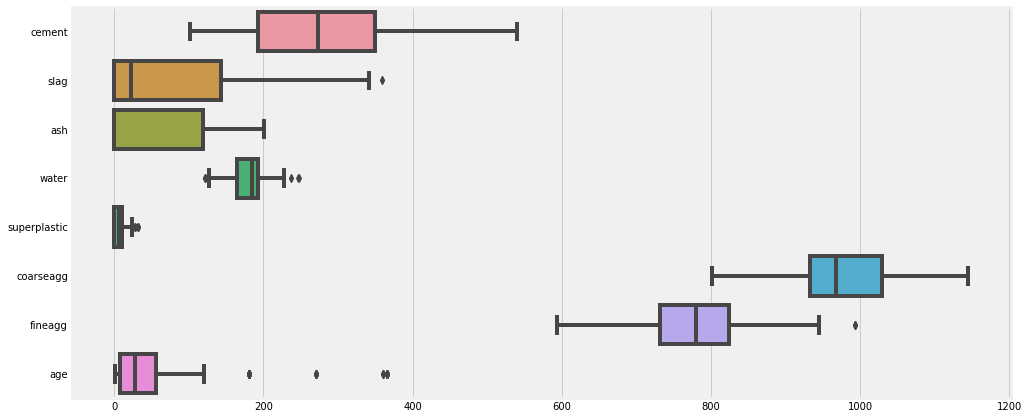

In [9]:
# A quick check to find columns that contain outliers
print('A quick check to find columns that contain outliers, graphical'); print('--'*60)

fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(data = concrete.iloc[:, 0:-1], orient = 'h')

Box plot, distribution of columns with and without outliers
------------------------------------------------------------------------------------------------------------------------
Cement column --------------------------------------------------------------------------------
Number of Observations with outliers: 0


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

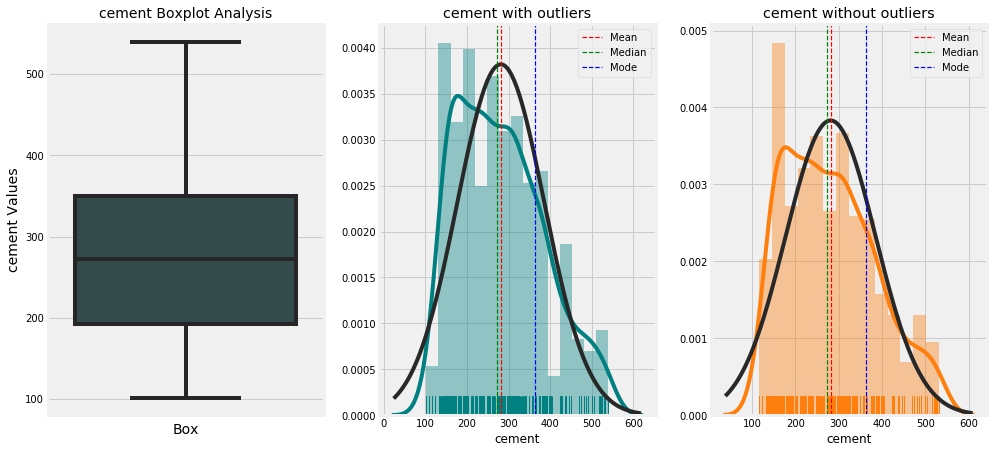

Slag column --------------------------------------------------------------------------------
Number of Observations with outliers: 2


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
918  239.60 359.40 0.00 185.70          0.00     941.60   664.30   28   
990  239.60 359.40 0.00 185.70          0.00     941.60   664.30    7   

     strength  
918     39.44  
990     25.42

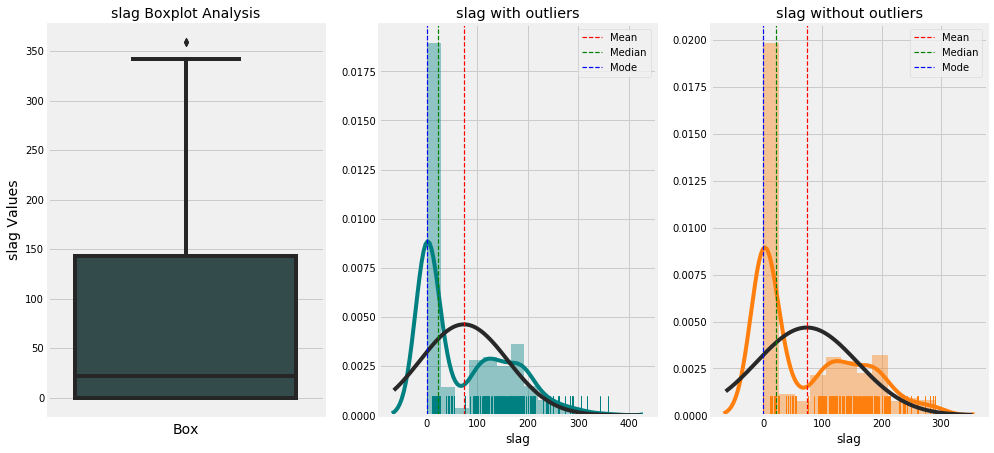

Ash column --------------------------------------------------------------------------------
Number of Observations with outliers: 0


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

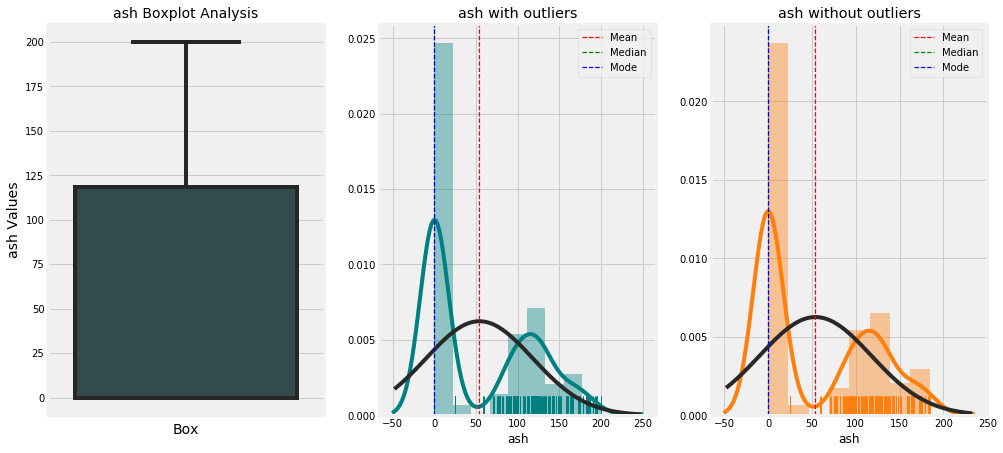

Water column --------------------------------------------------------------------------------
Number of Observations with outliers: 9


cement  slag    ash  water  superplastic  coarseagg  fineagg  age  \
66   237.00 92.00  71.00 247.00          6.00     853.00   695.00   28   
263  236.90 91.70  71.50 246.90          6.00     852.90   695.40   28   
432  168.00 42.10 163.80 121.80          5.70    1058.70   780.10   28   
462  168.00 42.10 163.80 121.80          5.70    1058.70   780.10  100   
587  168.00 42.10 163.80 121.80          5.70    1058.70   780.10    3   

     strength  
66      28.63  
263     28.63  
432     24.24  
462     39.23  
587      7.75

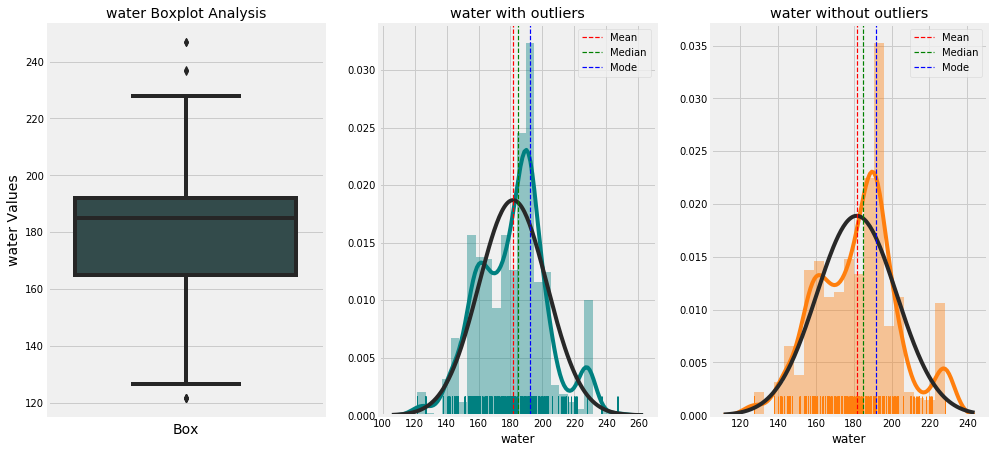

Superplastic column --------------------------------------------------------------------------------
Number of Observations with outliers: 10


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
44   531.30   0.00 0.00 141.80         28.20     852.10   893.70   91   
156  531.30   0.00 0.00 141.80         28.20     852.10   893.70   28   
232  469.00 117.20 0.00 137.80         32.20     852.10   840.50   56   
292  469.00 117.20 0.00 137.80         32.20     852.10   840.50   91   
538  531.30   0.00 0.00 141.80         28.20     852.10   893.70    7   

     strength  
44      59.20  
156     56.40  
232     69.30  
292     70.70  
538     46.90

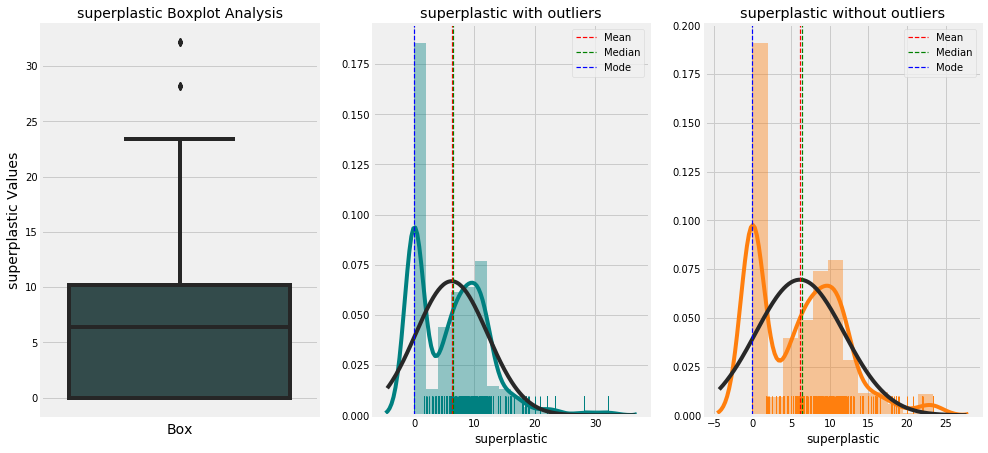

Coarseagg column --------------------------------------------------------------------------------
Number of Observations with outliers: 0


Empty DataFrame
Columns: [cement, slag, ash, water, superplastic, coarseagg, fineagg, age, strength]
Index: []

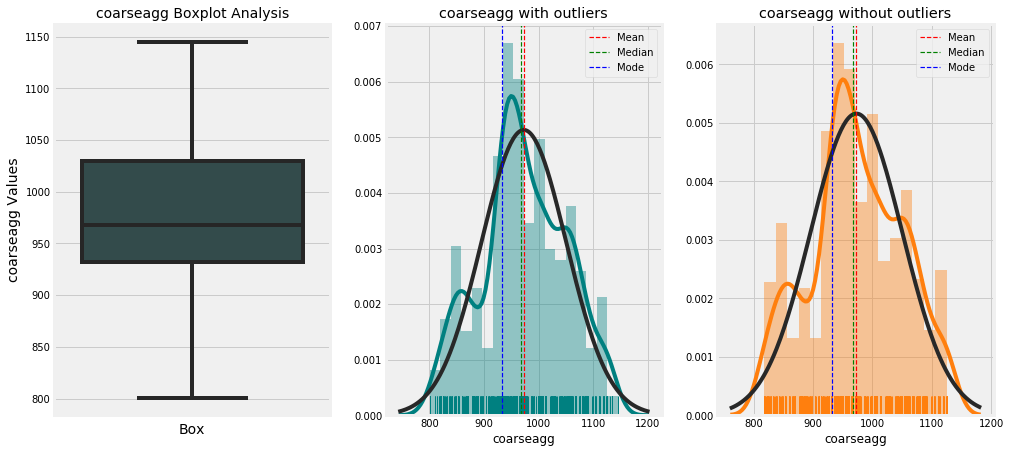

Fineagg column --------------------------------------------------------------------------------
Number of Observations with outliers: 5


cement  slag  ash  water  superplastic  coarseagg  fineagg  age  strength
129  375.00 93.80 0.00 126.60         23.40     852.10   992.60   91     62.50
447  375.00 93.80 0.00 126.60         23.40     852.10   992.60    7     45.70
504  375.00 93.80 0.00 126.60         23.40     852.10   992.60    3     29.00
584  375.00 93.80 0.00 126.60         23.40     852.10   992.60   56     60.20
857  375.00 93.80 0.00 126.60         23.40     852.10   992.60   28     56.70

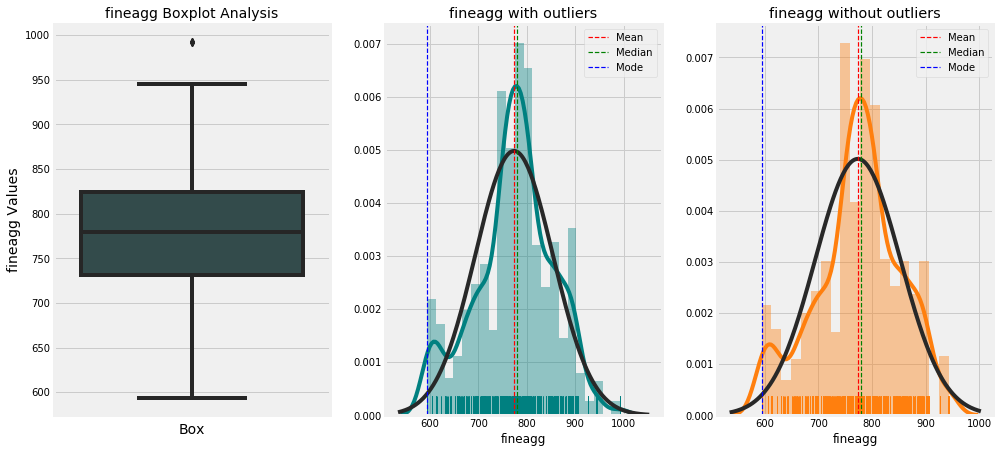

Age column --------------------------------------------------------------------------------
Number of Observations with outliers: 59


cement   slag  ash  water  superplastic  coarseagg  fineagg  age  \
51   331.00   0.00 0.00 192.00          0.00     978.00   825.00  180   
64   332.50 142.50 0.00 228.00          0.00     932.00   594.00  365   
93   427.50  47.50 0.00 228.00          0.00     932.00   594.00  180   
99   237.50 237.50 0.00 228.00          0.00     932.00   594.00  180   
103  380.00   0.00 0.00 228.00          0.00     932.00   670.00  180   

     strength  
51      39.00  
64      41.05  
93      41.84  
99      36.25  
103     53.10

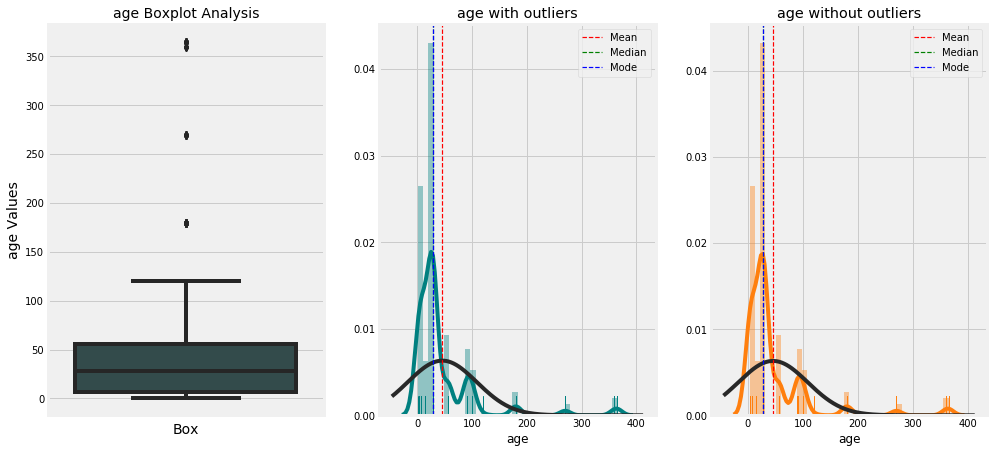

In [10]:
# Outlier, distribution for columns with outliers
print('Box plot, distribution of columns with and without outliers'); print('--'*60)

boxplotcolumns = list(concrete.columns)[:-1]
for cols in boxplotcolumns:
    Q3 = concrete[cols].quantile(0.75)
    Q1 = concrete[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    print(f'Number of Observations with outliers: {len(concrete.loc[(concrete[cols] < (Q1 - 1.5 * IQR)) | (concrete[cols] > (Q3 + 1.5 * IQR))])}')
    display(concrete.loc[(concrete[cols] < (Q1 - 1.5 * IQR)) | (concrete[cols] > (Q3 + 1.5 * IQR))].head())
    odp_plots(concrete, cols)

del cols, IQR, boxplotcolumns

In [11]:
# Replacing outliers with mean values in these columns
print('Replacing outliers with mean values using quantile method'); print('--'*60)

concrete_im = concrete.copy(deep = True)
outliers_cols = ['slag', 'water', 'superplastic', 'fineagg', 'age']

for col in outliers_cols:
    outliers(concrete_im, col, method = 'quantile', strategy = 'mean')

print('\nColumn for which outliers where replaced with mean using quantile method: \n', outliers_cols)

Replacing outliers with mean values using quantile method
------------------------------------------------------------------------------------------------------------------------
Outliers for slag are: [359.4, 359.4]

Outliers for water are: [121.8, 121.8, 121.8, 121.8, 121.8, 236.7, 237.0, 246.9, 247.0]

Outliers for superplastic are: [28.2, 28.2, 28.2, 28.2, 28.2, 32.2, 32.2, 32.2, 32.2, 32.2]

Outliers for fineagg are: [992.6, 992.6, 992.6, 992.6, 992.6]

Outliers for age are: [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 360, 360, 360, 360, 360, 360, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365]


Column for which outliers where replaced with mean using quantile method: 
 ['slag', 'water', 'superplastic', 'fineagg', 'age']


In [12]:
print('Descriptive stats before outlier removal for columns with outliers'); print('--'*50); display(concrete[outliers_cols].describe().T)
print('\n Descriptive stats after outlier removal for columns with outliers'); print('--'*50); display(concrete_im[outliers_cols].describe().T)

Descriptive stats before outlier removal for columns with outliers
----------------------------------------------------------------------------------------------------


count   mean   std    min    25%    50%    75%    max
slag         1030.00  73.90 86.28   0.00   0.00  22.00 142.95 359.40
water        1030.00 181.57 21.35 121.80 164.90 185.00 192.00 247.00
superplastic 1030.00   6.20  5.97   0.00   0.00   6.40  10.20  32.20
fineagg      1030.00 773.58 80.18 594.00 730.95 779.50 824.00 992.60
age          1030.00  45.66 63.17   1.00   7.00  28.00  56.00 365.00


 Descriptive stats after outlier removal for columns with outliers
----------------------------------------------------------------------------------------------------


count   mean   std    min    25%    50%    75%    max
slag         1030.00  73.34 85.35   0.00   0.00  22.00 142.73 342.10
water        1030.00 181.62 20.60 126.60 164.90 185.00 192.00 228.00
superplastic 1030.00   5.97  5.48   0.00   0.00   6.20  10.07  23.40
fineagg      1030.00 772.52 78.70 594.00 730.95 778.90 822.20 945.00
age          1030.00  33.27 27.95   1.00   7.00  28.00  45.66 120.00

After Imputation,Median remain unchanged while mean changes slightly not significantly. Type of skewness remain unchanged.

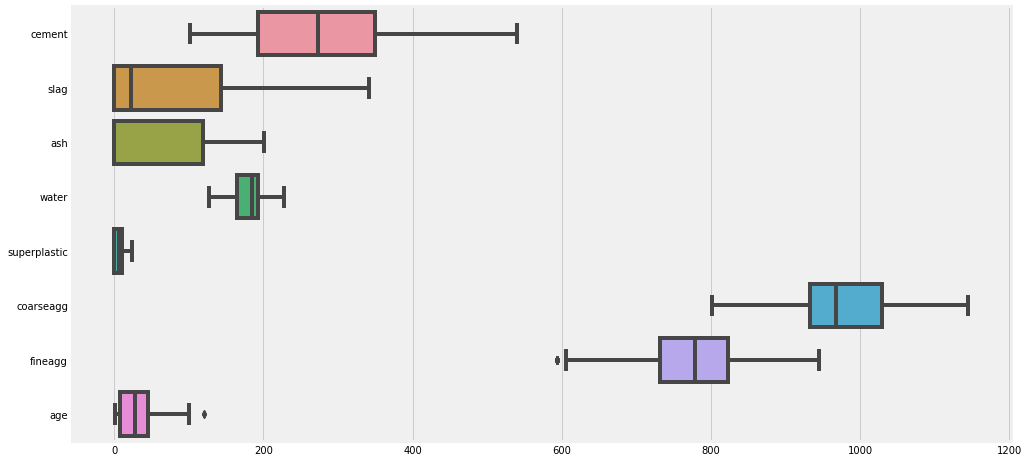

In [13]:
# A quick check to detect columns that contain outliers
fig = plt.figure(figsize = (15, 8))
ax = sns.boxplot(data = concrete_im.iloc[:, 0:-1], orient = 'h')

# 1.b. Multivariate analysis

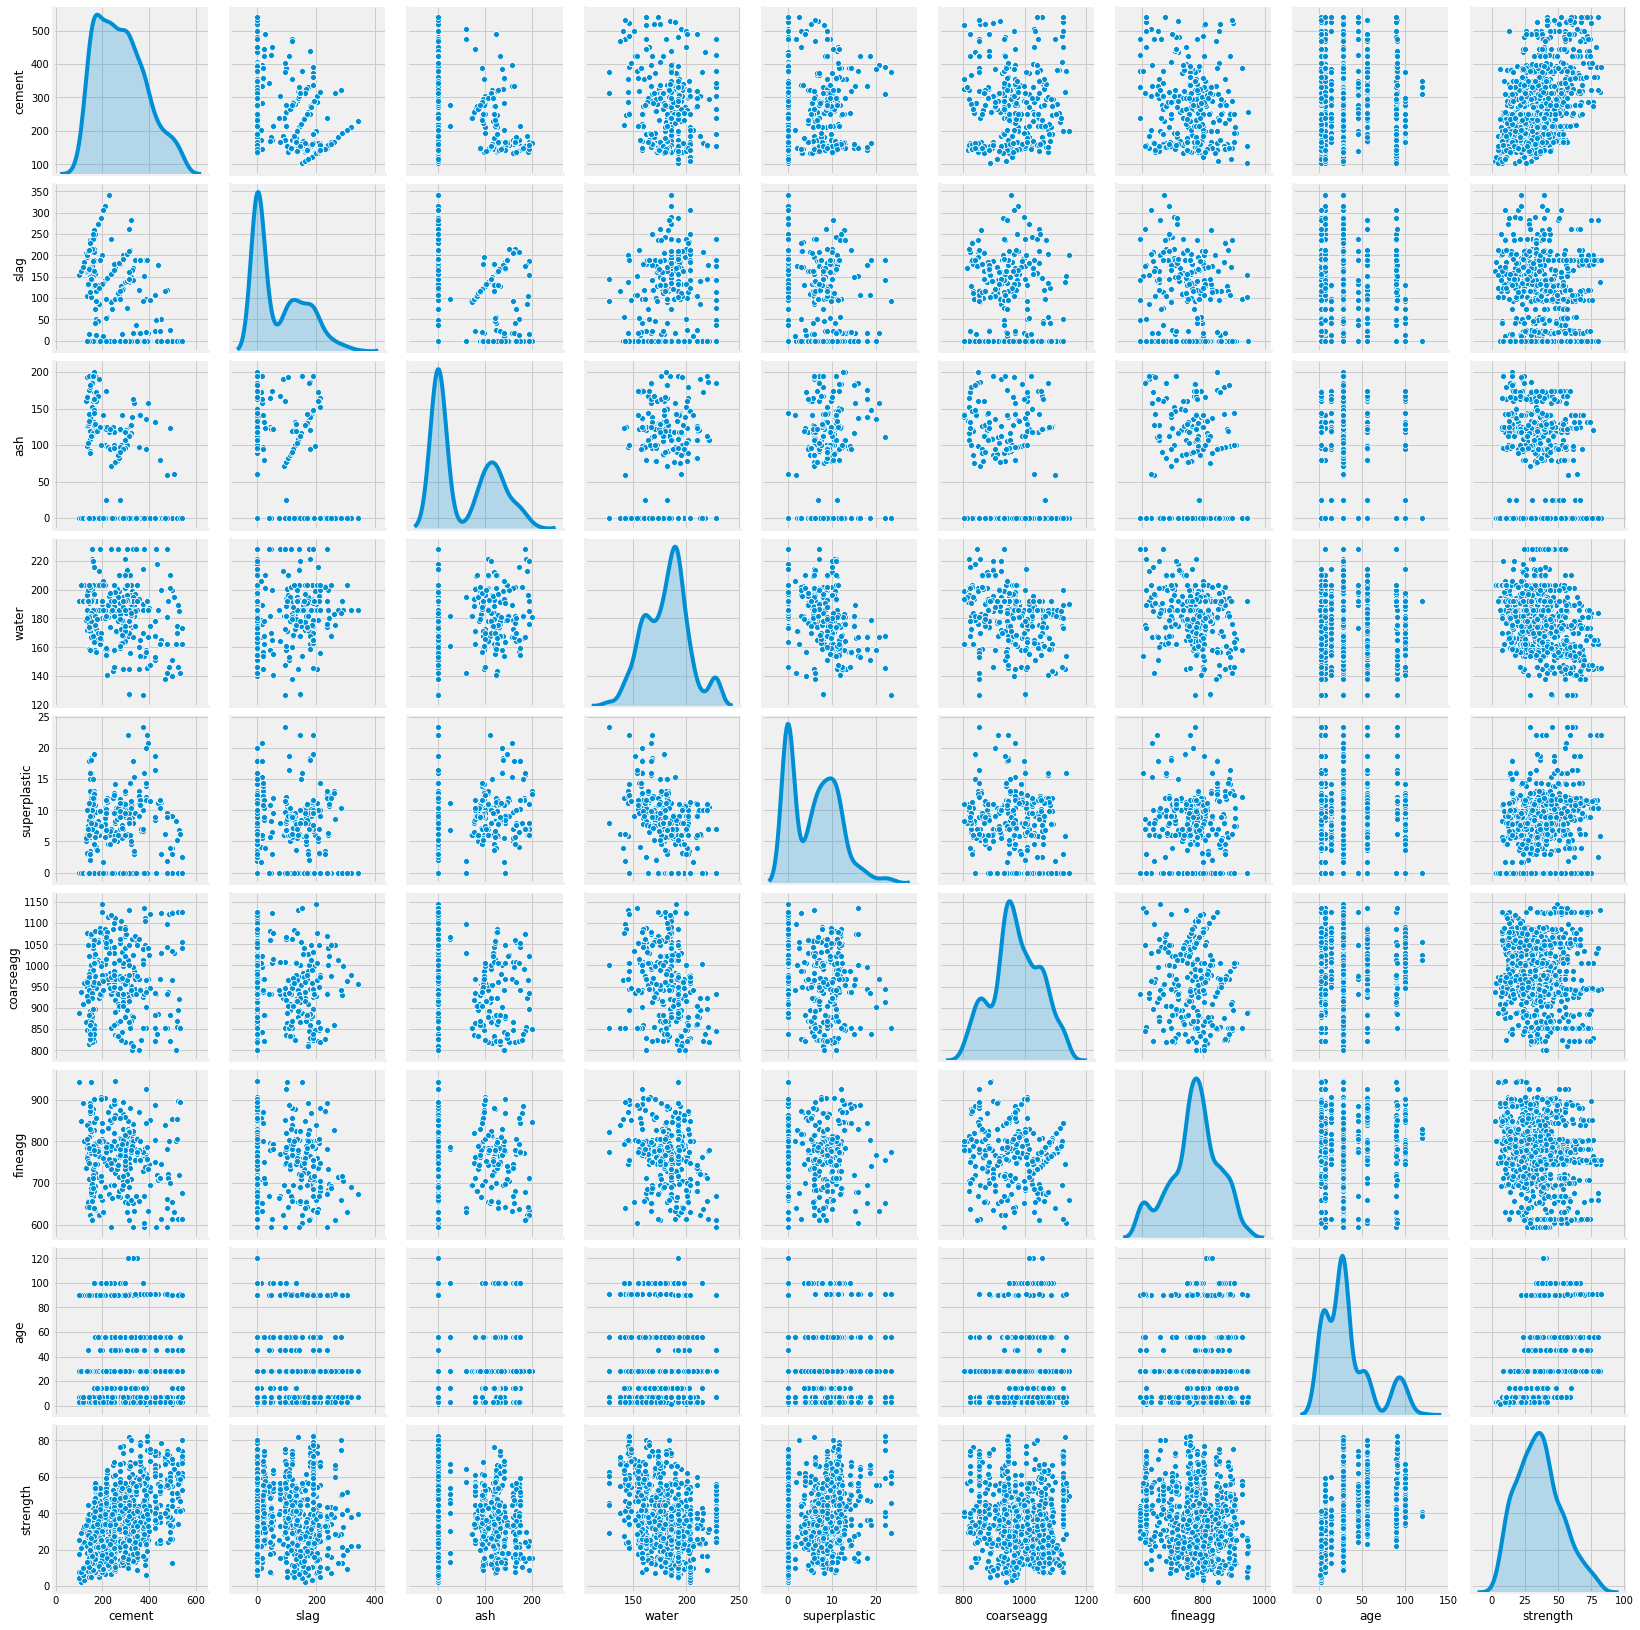

In [14]:
#Bivariate Analysis between the predictor variables using Pair Plot
sns.pairplot(concrete_im, diag_kind = 'kde');

Cement and strength have a linear relationship.

Column that have bi/multimodal distributions are slag, ash and superplastic.

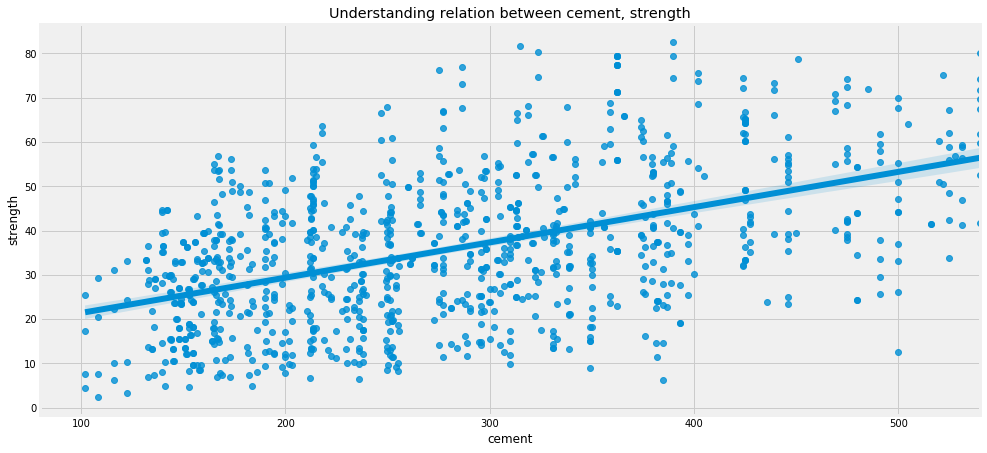

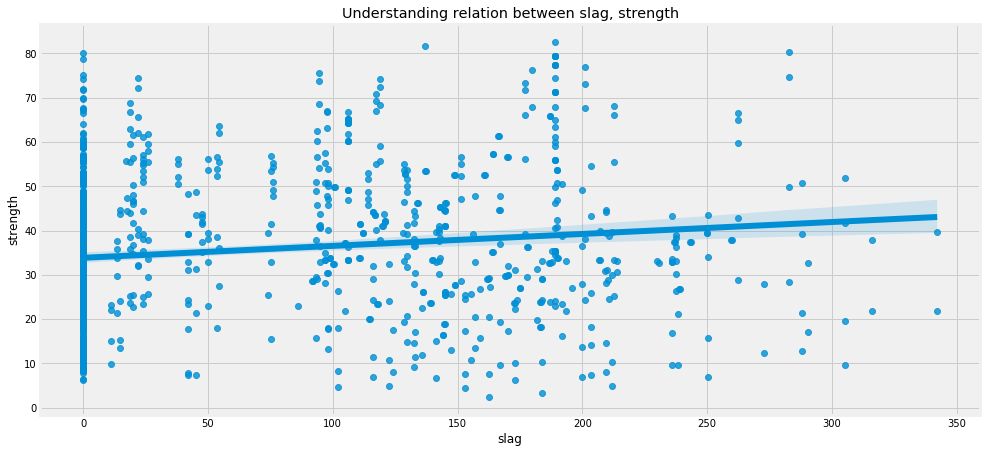

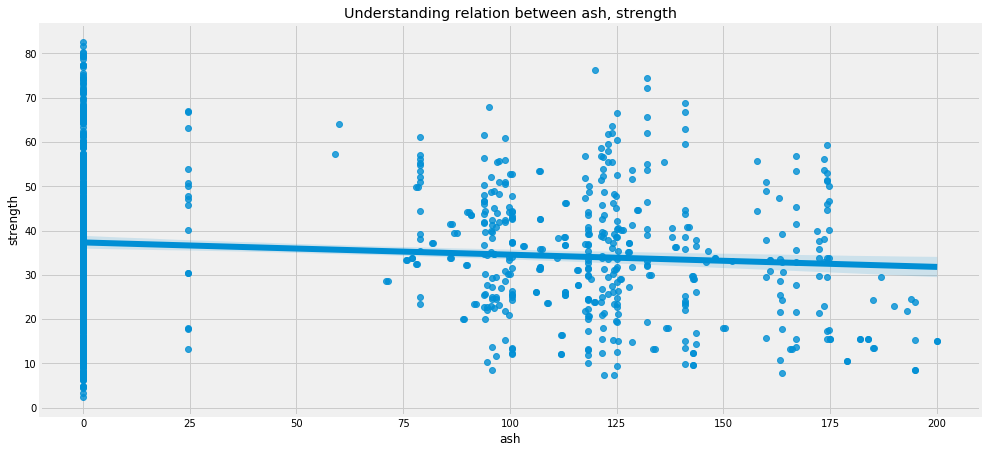

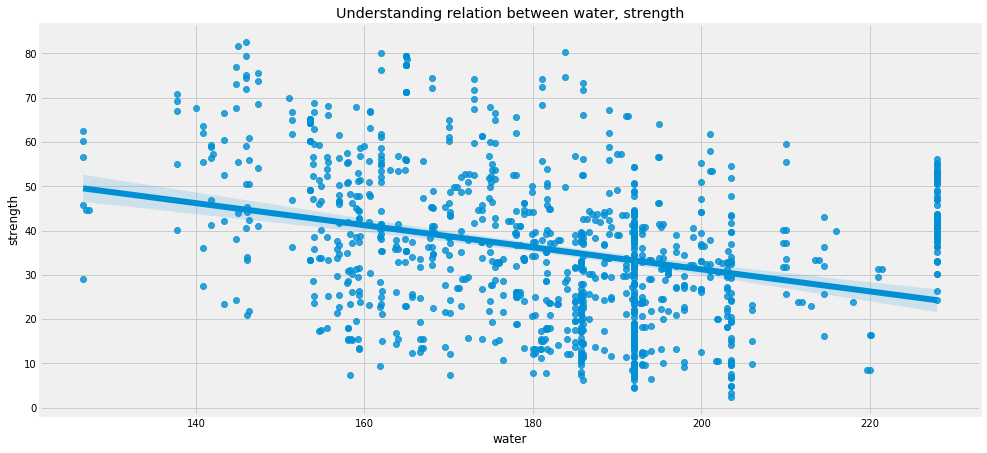

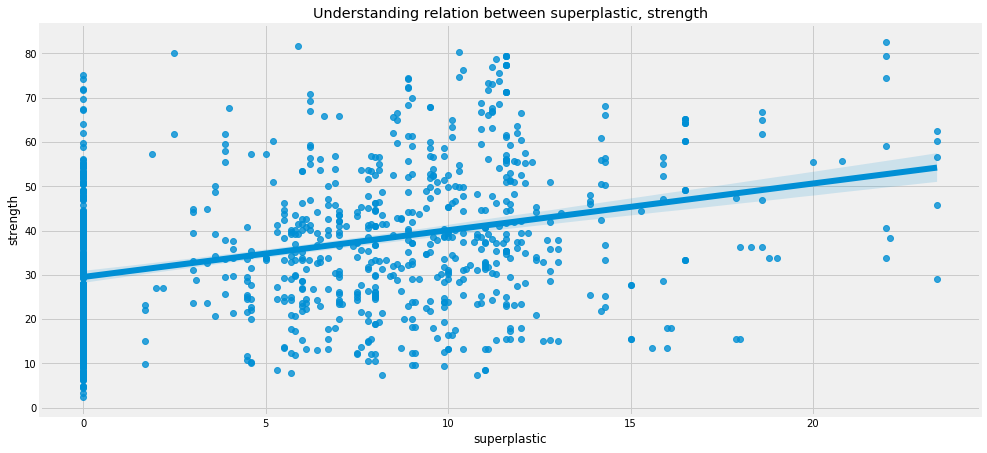

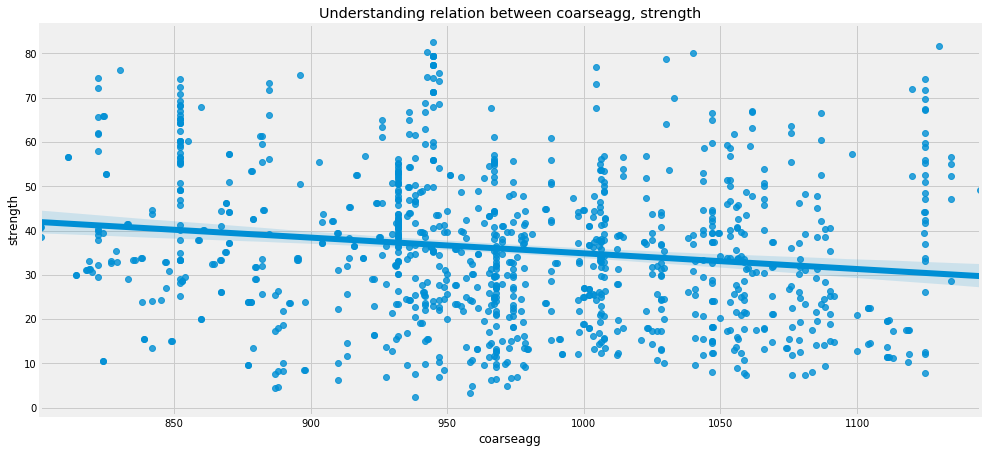

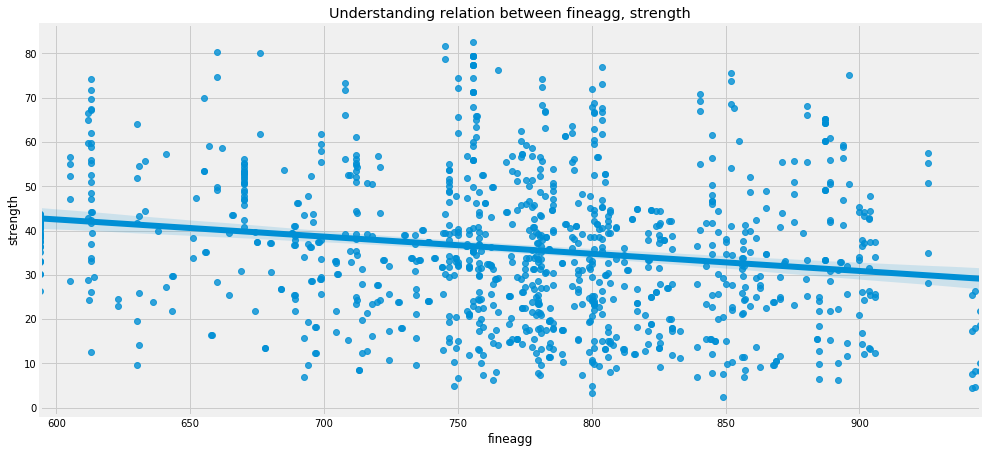

In [16]:
#Bivariate Analysis between the predictor variables and target column
for col in list(concrete_im.columns)[:-2]:
    fig, ax1 = plt.subplots(figsize = (15, 7.2), ncols = 1, sharex = False)
    sns.regplot(x = concrete_im[col], y = concrete_im['strength'], ax = ax1).set_title(f'Understanding relation between {col}, strength')

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     365.7
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          1.53e-293
Time:                        22:08:33   Log-Likelihood:                -3664.9
No. Observations:                1030   AIC:                             7348.
Df Residuals:                    1021   BIC:                             7392.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       32.1465     18.667      1.722   

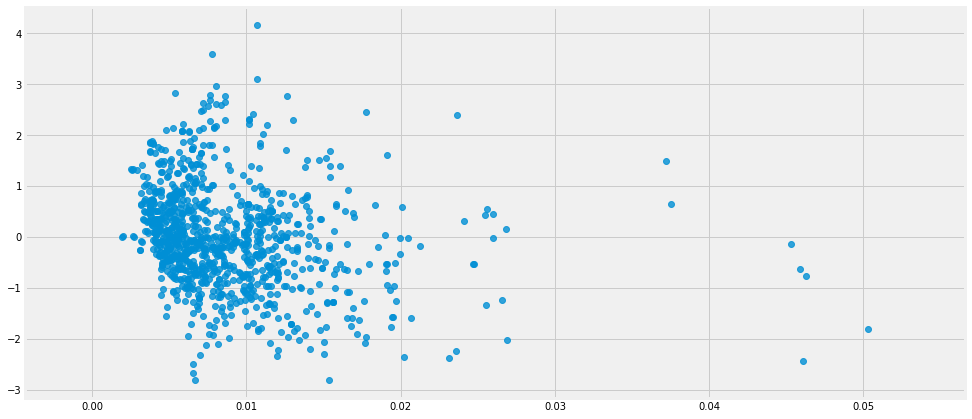

In [18]:
#Check Presence of leverage points

lm = smf.ols(formula = 'strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age', data = concrete_im).fit()
print(lm.summary())

influence = lm.get_influence()
resid_student = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

print('\n')
print('Leverage v.s. Studentized Residuals')
fig = plt.figure(figsize = (15, 7.2))
sns.regplot(leverage, lm.resid_pearson,  fit_reg = False)

In [19]:
concrete_im_res = pd.concat([pd.Series(cooks, name = 'cooks'), pd.Series(dffits, name = 'dffits'), pd.Series(leverage, name = 'leverage'), pd.Series(resid_student, name = 'resid_student')], axis = 1)
concrete_im_res = pd.concat([concrete_im, concrete_im_res], axis = 1)
concrete_im_res.head()

cement   slag    ash  water  superplastic  coarseagg  fineagg   age  \
0  141.30 212.00   0.00 203.50          0.00     971.80   748.50 28.00   
1  168.90  42.20 124.30 158.30         10.80    1080.80   796.20 14.00   
2  250.00   0.00  95.70 187.40          5.50     956.90   861.20 28.00   
3  266.00 114.00   0.00 228.00          0.00     932.00   670.00 28.00   
4  154.80 183.40   0.00 193.30          9.10    1047.40   696.70 28.00   

   strength  cooks  dffits  leverage  resid_student  
0     29.89   0.00    0.07      0.01           0.86  
1     23.51   0.00   -0.00      0.01          -0.02  
2     29.22   0.00    0.03      0.00           0.48  
3     45.85   0.00    0.21      0.01           2.49  
4     18.29   0.00   -0.10      0.01          -0.96

In [21]:
# Studentized Residual
print('Studentized residuals as a first means for identifying outliers'); print('--'*60)
r = concrete_im_res.resid_student
print('-'*30 + ' studentized residual ' + '-'*30)
display(r.describe())
print('\n')

r_sort = concrete_im_res.sort_values(by = 'resid_student', ascending = True)
print('-'*30 + ' top 5 most negative residuals ' + '-'*30)
display(r_sort.head())
print('\n')

r_sort = concrete_im_res.sort_values(by = 'resid_student', ascending = False)
print('-'*30 + ' top 5 most positive residuals ' + '-'*30)
display(r_sort.head())

Studentized residuals as a first means for identifying outliers
------------------------------------------------------------------------------------------------------------------------
------------------------------ studentized residual ------------------------------


count   1030.00
mean      -0.00
std        1.00
min       -2.83
25%       -0.62
50%       -0.06
75%        0.55
max        4.22
Name: resid_student, dtype: float64



------------------------------ top 5 most negative residuals ------------------------------


cement   slag   ash  water  superplastic  coarseagg  fineagg  age  \
502  500.00   0.00  0.00 200.00          0.00    1125.00   613.00 1.00   
503  362.60 189.00  0.00 164.90         11.60     944.70   755.80 7.00   
786  446.00  24.00 79.00 162.00         11.60     967.00   712.00 3.00   
504  375.00  93.80  0.00 126.60         23.40     852.10   773.58 3.00   
993  446.00  24.00 79.00 162.00         11.60     967.00   712.00 3.00   

     strength  cooks  dffits  leverage  resid_student  
502     12.64   0.01   -0.35      0.02          -2.83  
503     22.90   0.01   -0.23      0.01          -2.83  
786     23.35   0.01   -0.22      0.01          -2.69  
504     29.00   0.03   -0.55      0.05          -2.50  
993     25.02   0.00   -0.20      0.01          -2.50



------------------------------ top 5 most positive residuals ------------------------------


cement   slag    ash  water  superplastic  coarseagg  fineagg   age  \
192  315.00 137.00   0.00 145.00          5.90    1130.00   745.00 28.00   
506  451.00   0.00   0.00 165.00         11.30    1030.00   745.00 28.00   
491  275.00 180.00 120.00 162.00         10.40     830.00   765.00 28.00   
713  190.00 190.00   0.00 228.00          0.00     932.00   670.00 45.66   
964  277.20  97.80  24.50 160.70         11.20    1061.70   782.50 28.00   

     strength  cooks  dffits  leverage  resid_student  
192     81.75   0.02    0.44      0.01           4.22  
506     78.80   0.01    0.32      0.01           3.63  
491     76.24   0.01    0.33      0.01           3.14  
713     53.69   0.01    0.27      0.01           3.00  
964     63.14   0.00    0.21      0.01           2.86

studentized residuals that exceed +2 or -2, and get even more concerned about residuals that exceed +2.5 or -2.5 and even yet more concerned about residuals that exceed +3 or -3.

In [22]:
print('Printing indexes where studentized residual exceeds +2 or -2'); print('--'*50)
res_index = concrete_im_res[abs(r) > 2].index
print(res_index)

Printing indexes where studentized residual exceeds +2 or -2
----------------------------------------------------------------------------------------------------
Int64Index([   3,   44,   50,   96,  103,  128,  147,  159,  161,  192,  198,
             207,  262,  264,  272,  302,  329,  334,  349,  370,  383,  393,
             434,  452,  469,  491,  502,  503,  504,  506,  510,  518,  525,
             530,  539,  545,  556,  570,  606,  623,  632,  713,  732,  734,
             738,  762,  786,  824,  831,  902,  908,  964,  967,  973,  981,
             993,  995, 1003, 1009, 1021, 1028],
           dtype='int64')


In [23]:
print('leverage points to identify observations that  have potential great influence on reg coefficient estimates.'); print('--'*50)

leverage = concrete_im_res.leverage
print('-'*30 + ' Leverage ' + '-'*30)
display(leverage.describe())
print('\n')

leverage_sort = concrete_im_res.sort_values(by = 'leverage', ascending = False)

print('-'*30 + ' top 5 highest leverage data points ' + '-'*30)
display(leverage_sort.head())

leverage points to identify observations that  have potential great influence on reg coefficient estimates.
----------------------------------------------------------------------------------------------------
------------------------------ Leverage ------------------------------


count   1030.00
mean       0.01
std        0.01
min        0.00
25%        0.01
50%        0.01
75%        0.01
max        0.05
Name: leverage, dtype: float64



------------------------------ top 5 highest leverage data points ------------------------------


cement  slag  ash  water  superplastic  coarseagg  fineagg   age  \
129  375.00 93.80 0.00 126.60         23.40     852.10   773.58 91.00   
584  375.00 93.80 0.00 126.60         23.40     852.10   773.58 56.00   
504  375.00 93.80 0.00 126.60         23.40     852.10   773.58  3.00   
447  375.00 93.80 0.00 126.60         23.40     852.10   773.58  7.00   
857  375.00 93.80 0.00 126.60         23.40     852.10   773.58 28.00   

     strength  cooks  dffits  leverage  resid_student  
129     62.50   0.02   -0.43      0.05          -1.86  
584     60.20   0.00   -0.17      0.05          -0.79  
504     29.00   0.03   -0.55      0.05          -2.50  
447     45.70   0.00   -0.14      0.05          -0.65  
857     56.70   0.00   -0.03      0.05          -0.13

Series([], dtype: float64)

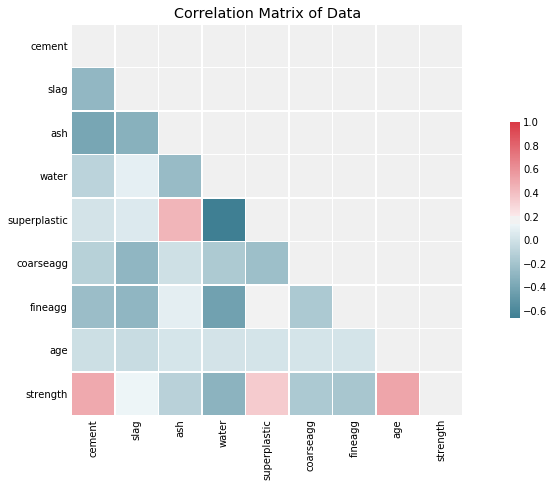

In [24]:
# Print Correlation matrix
correlation_matrix(concrete_im,threshold = 0.8)

In [25]:
# Absolute correlation of independent Features with the Target Features
absCorrwithDep = []
allVars = concrete_im.drop('strength', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(concrete_im['strength'].corr(concrete_im[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

Variable Correlation
7           age        0.52
0        cement        0.50
4  superplastic        0.35
3         water        0.31
6       fineagg        0.18
5     coarseagg        0.16
1          slag        0.14
2           ash        0.11

None of the Features have a correlation above a threshold and so none to be dropped out.

Age, Cement and Superplastic are some of the Features that have strong influence over Target variable.

# 2. Deliverable -2 (Feature Engineering techniques)

# 2.c. Explore for gaussians. If data is likely to be a mix of gaussians, explore individual clusters and present your findings in terms of the independent attributes and their suitability to predict strength

# Cluster Analysis

In [26]:
concrete_im.reset_index(inplace = True, drop = True)

X = concrete_im.drop('strength', axis = 1)
y = concrete_im['strength']
labels = KMeans(2, random_state = random_state).fit_predict(X)

Cement vs other columns clusters
----------------------------------------------------------------------------------------------------


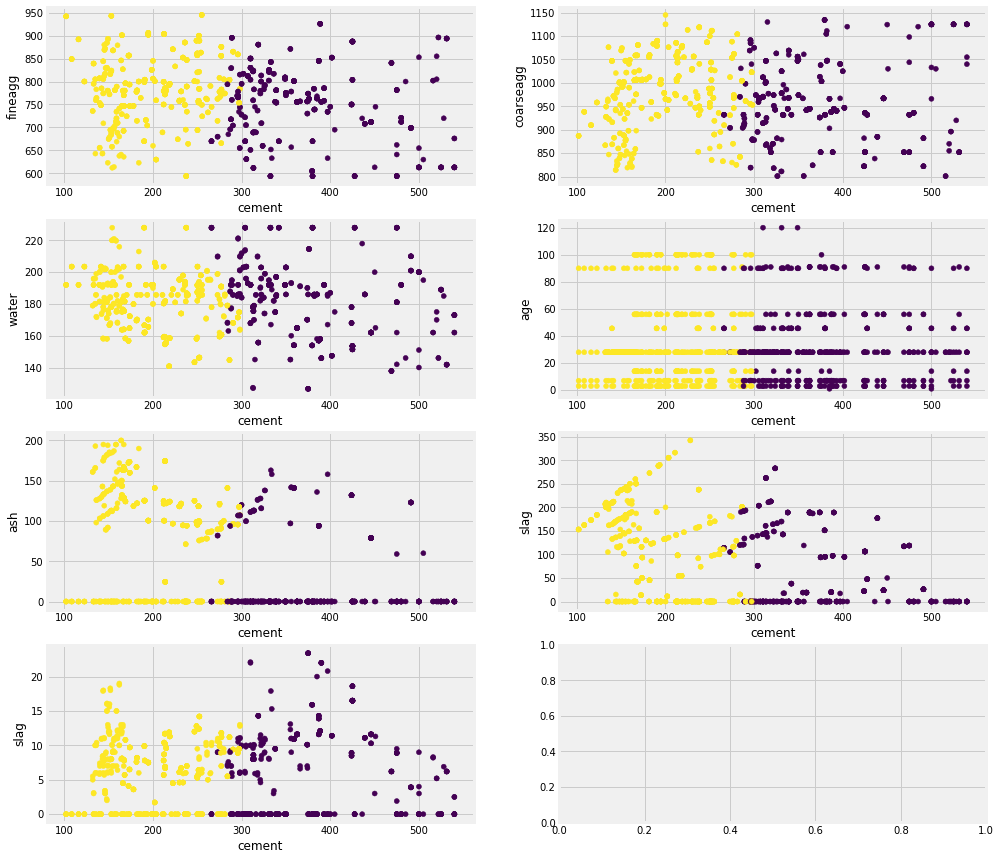

In [27]:
print('Cement vs other columns clusters'); print('--'*50)
kmeans_plots(X, 'cement')

Slag vs other columns clusters
----------------------------------------------------------------------------------------------------


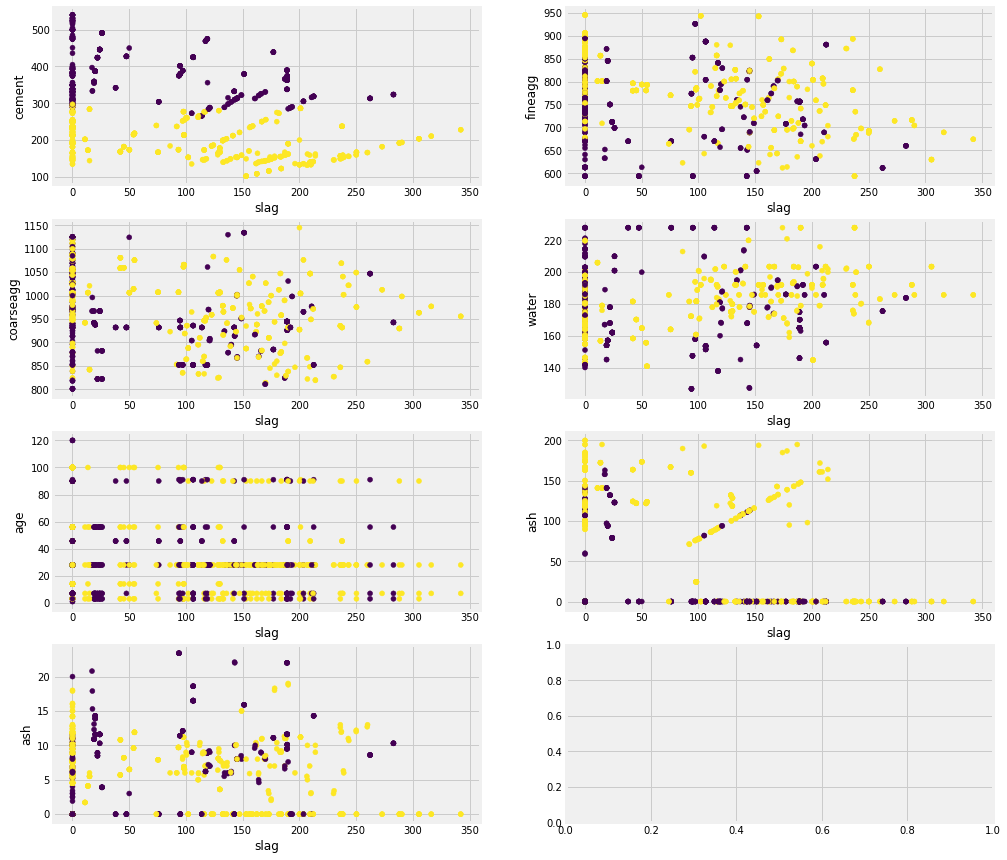

In [28]:
print('Slag vs other columns clusters'); print('--'*50)
kmeans_plots(X, 'slag')

Ash vs other columns clusters
----------------------------------------------------------------------------------------------------


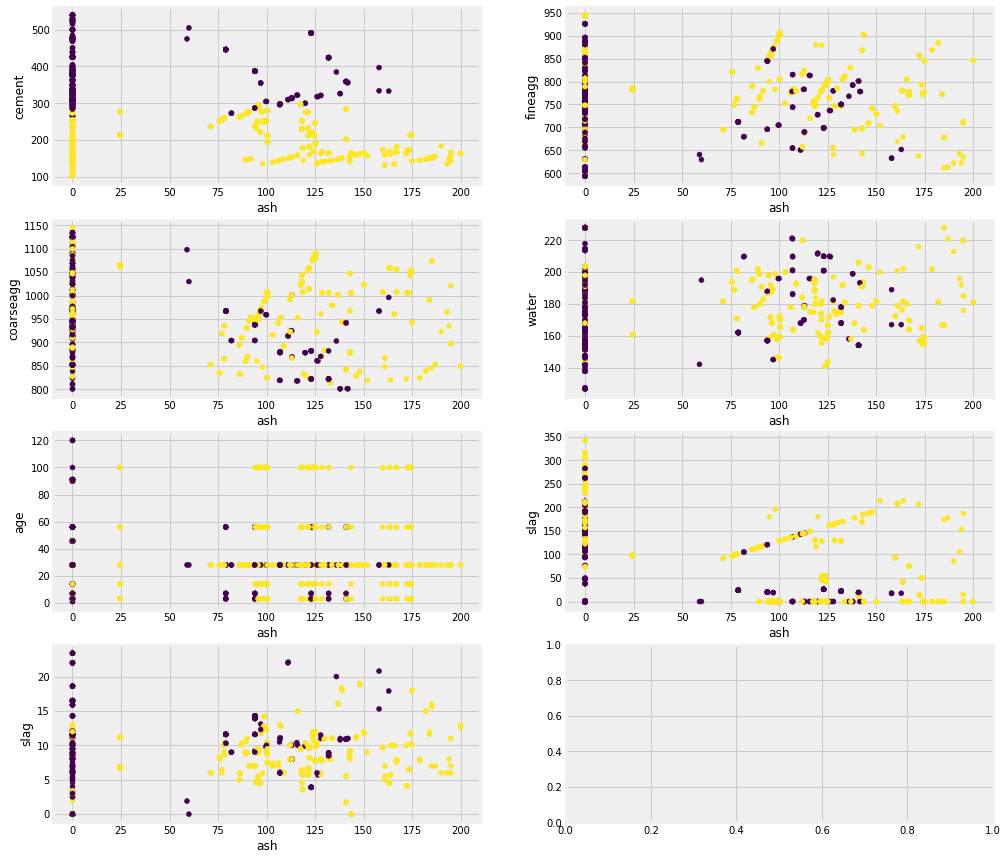

In [29]:
print('Ash vs other columns clusters'); print('--'*50)
kmeans_plots(X, 'ash')

Water vs other columns clusters
----------------------------------------------------------------------------------------------------


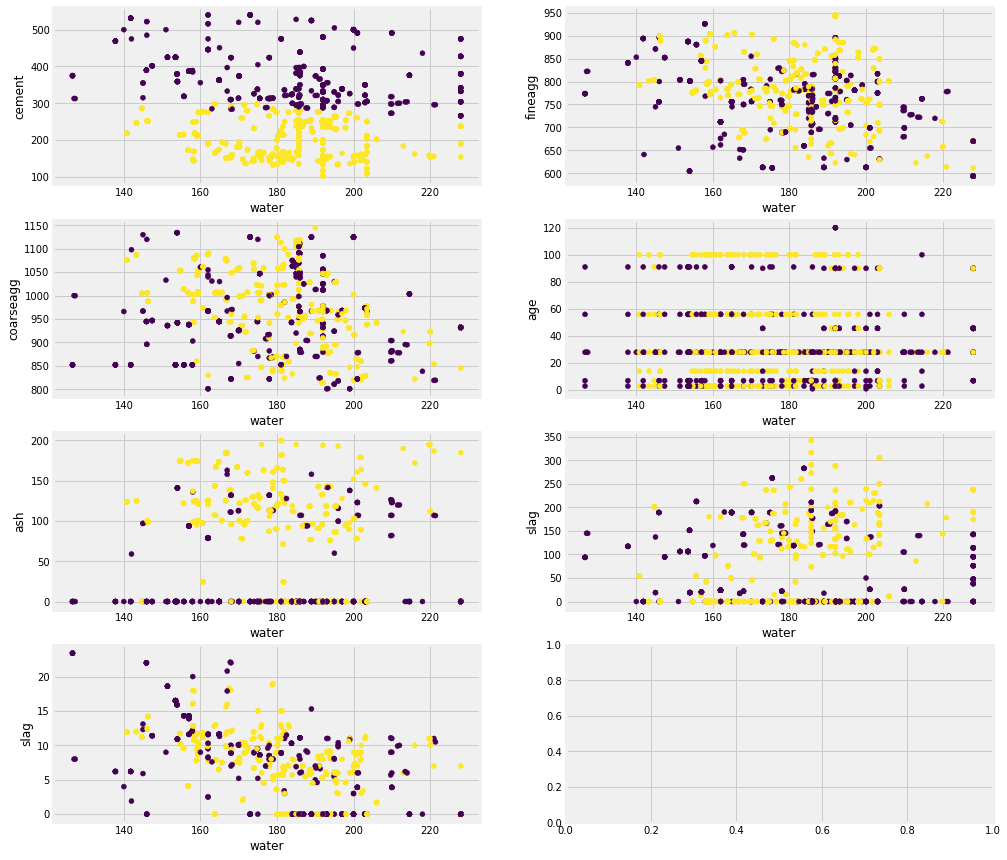

In [30]:
print('Water vs other columns clusters'); print('--'*50)
kmeans_plots(X, 'water')

Superplastic vs other columns clusters
----------------------------------------------------------------------------------------------------


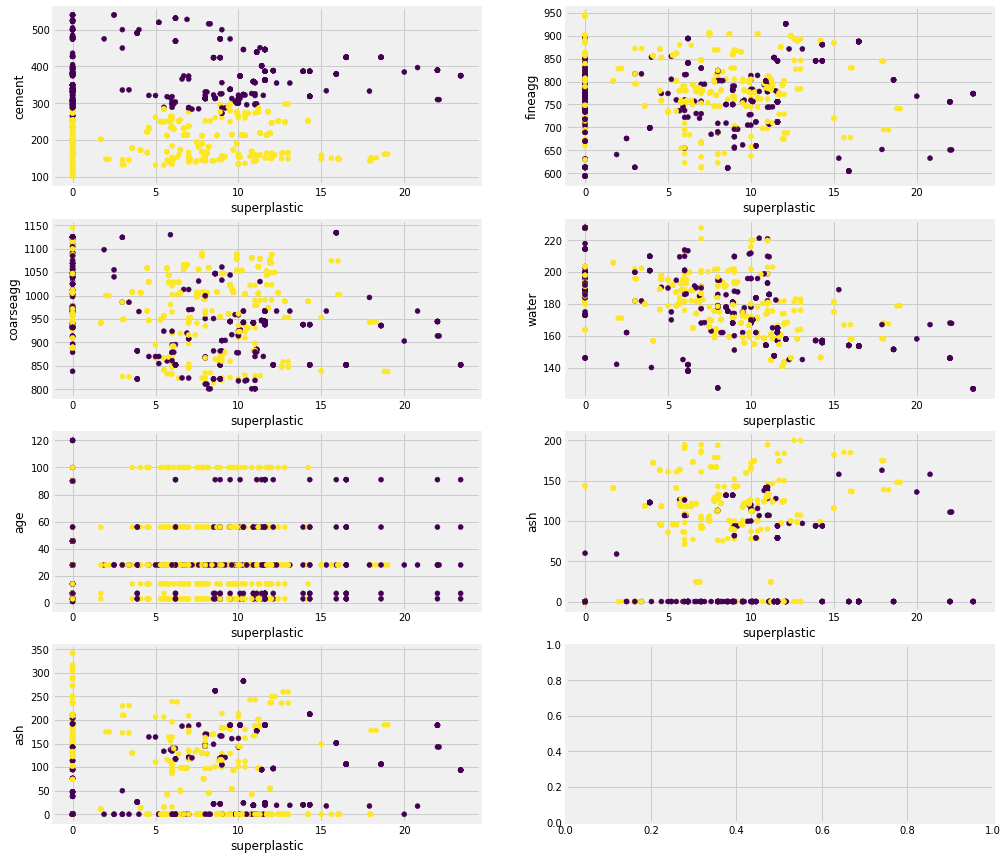

In [31]:
print('Superplastic vs other columns clusters'); print('--'*50)
kmeans_plots(X, 'superplastic')

Coarseagg vs other columns clusters
----------------------------------------------------------------------------------------------------


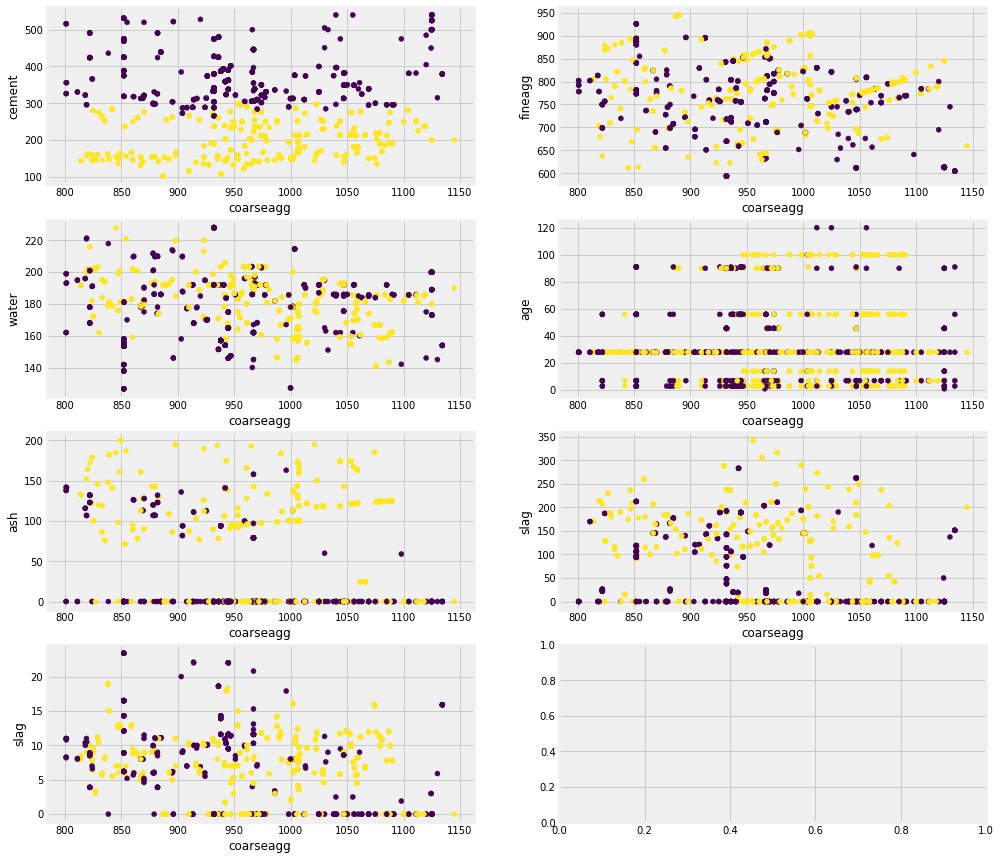

In [32]:
print('Coarseagg vs other columns clusters'); print('--'*50)
kmeans_plots(X, 'coarseagg')

Fineagg vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


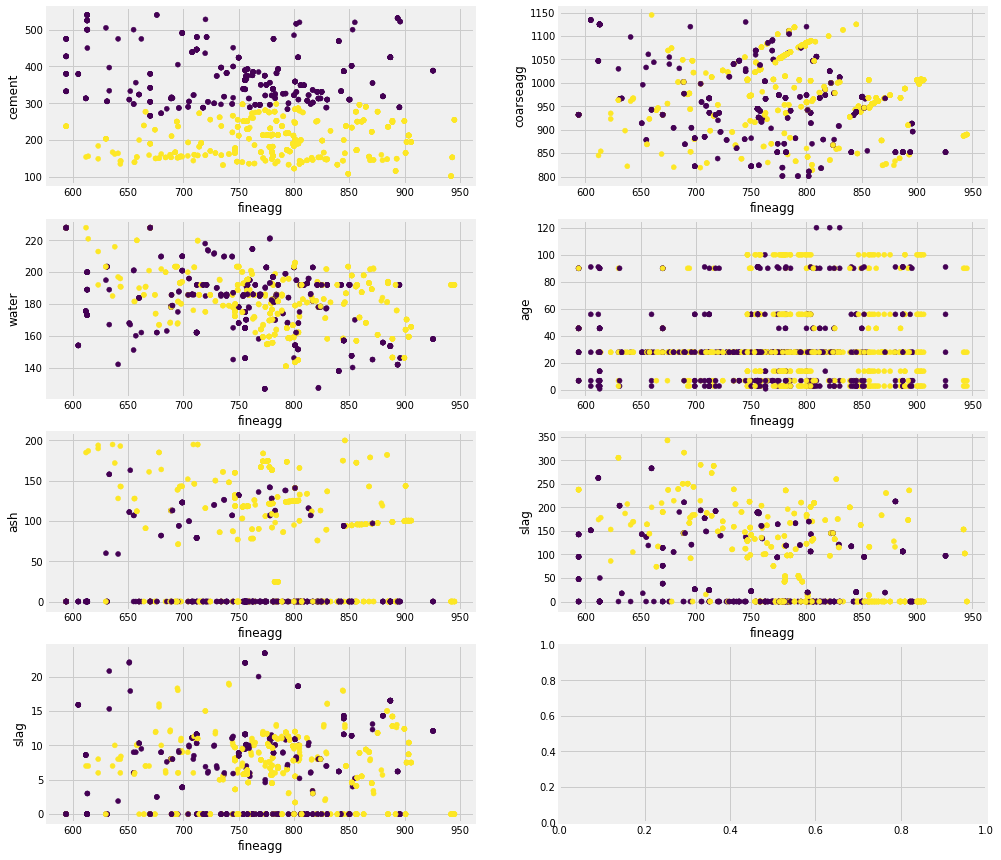

In [33]:
print('Fineagg vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'fineagg')

Age vs other columns clusters
------------------------------------------------------------------------------------------------------------------------


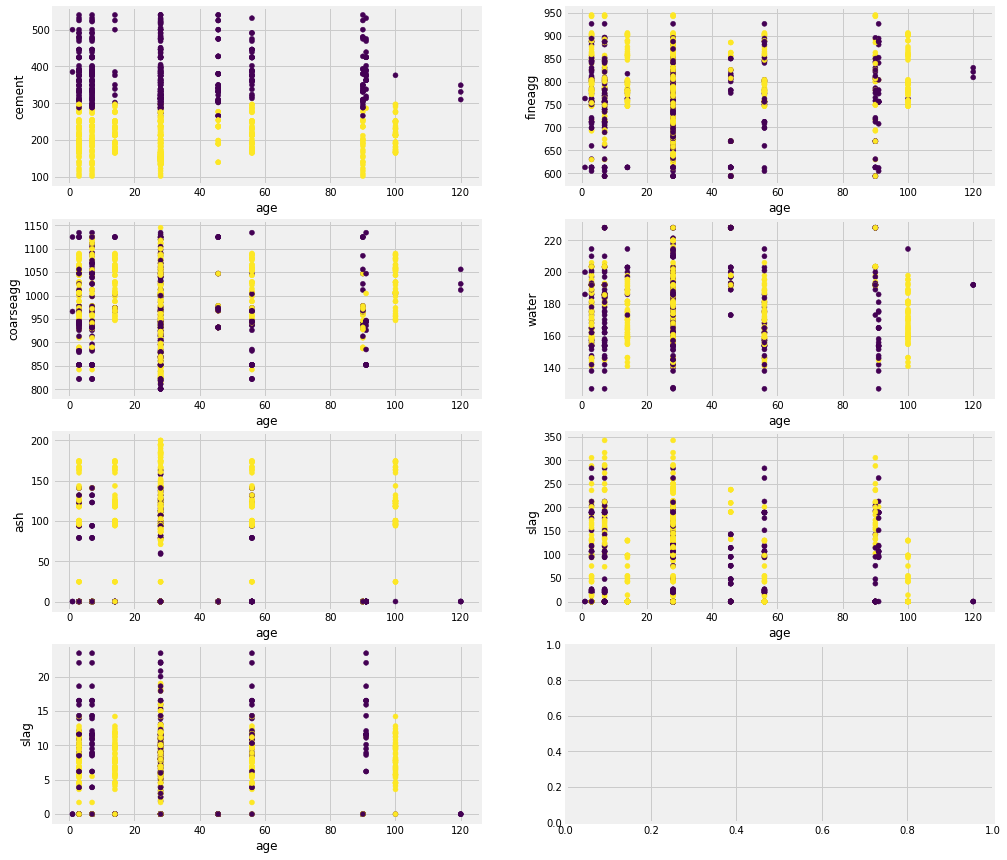

In [34]:
print('Age vs other columns clusters'); print('--'*60)
kmeans_plots(X, 'age')

Clusters can be seen  between cement and rest of the independent variables.

Cluster at age 100 can be seen.

# 2.a. Identify opportunities (if any) to create a composite feature, drop a feature etc.

# Adding features based on cluster analysis

In [35]:
print('Let\'s add features based on cluster analysis we found for cement and other columns'); print('--'*60)

concrete_im = concrete_im.join(pd.DataFrame(labels, columns = ['labels']), how = 'left')
cement_features = concrete_im.groupby('labels', as_index = False)['cement'].agg(['mean', 'median'])
concrete_im = concrete_im.merge(cement_features, on = 'labels', how = 'left')
concrete_im.rename(columns = {'mean': 'cement_labels_mean', 'median': 'cement_labels_median'}, inplace = True)
concrete_im.drop('labels', axis = 1, inplace = True)
display(custom_describe(concrete_im))

Let's add features based on cluster analysis we found for cement and other columns
------------------------------------------------------------------------------------------------------------------------


Count     Type   Mean  StandardDeviation  Variance  \
                                                                           
cement                 1030  float64 281.17             104.51  10921.58   
slag                   1030  float64  73.34              85.35   7285.39   
ash                    1030  float64  54.19              64.00   4095.62   
water                  1030  float64 181.62              20.60    424.39   
superplastic           1030  float64   5.97               5.48     30.00   
coarseagg              1030  float64 972.92              77.75   6045.68   
fineagg                1030  float64 772.52              78.70   6193.97   
age                    1030  float64  33.27              27.95    781.29   
strength               1030  float64  35.82              16.71    279.08   
cement_labels_mean     1030  float64 281.17              86.59   7498.68   
cement_labels_median   1030  float64 273.88              79.90   6383.39   

                      Minimum     Q1  Median      Q3  Maximum  Range    IQR  \
                                                                              
cement                 102.00 192.38  272.90  350.00   540.00 438.00 157.62   
slag                     0.00   0.00   22.00  142.73   342.10 342.10 142.73   
ash                      0.00   0.00    0.00  118.30   200.10 200.10 118.30   
water                  126.60 164.90  185.00  192.00   228.00 101.40  27.10   
superplastic             0.00   0.00    6.20   10.07    23.40  23.40  10.07   
coarseagg              801.00 932.00  968.00 1029.40  1145.00 344.00  97.40   
fineagg                594.00 730.95  778.90  822.20   945.00 351.00  91.25   
age                      1.00   7.00   28.00   45.66   120.00 119.00  38.66   
strength                 2.33  23.71   34.45   46.14    82.60  80.27  22.43   
cement_labels_mean     203.26 203.26  203.26  377.33   377.33 174.07 174.07   
cement_labels_median   202.00 202.00  202.00  362.60   362.60 160.60 160.60   

                      Kurtosis  Skewness  MeanAbsoluteDeviation  \
                                                                  
cement                   -0.52      0.51                  86.78   
slag                     -0.62      0.77                  76.30   
ash                      -1.33      0.54                  60.42   
water                    -0.04      0.09                  16.39   
superplastic             -0.44      0.47                   4.69   
coarseagg                -0.60     -0.04                  62.80   
fineagg                  -0.19     -0.33                  60.92   
age                       0.54      1.16                  21.09   
strength                 -0.31      0.42                  13.46   
cement_labels_mean       -1.96      0.21                  86.08   
cement_labels_median     -1.96      0.21                  79.42   

                                 SkewnessComment OutliersComment  
                                                                  
cement                 Moderately Skewed (Right)      NoOutliers  
slag                   Moderately Skewed (Right)      NoOutliers  
ash                    Moderately Skewed (Right)      NoOutliers  
water                  Fairly Symmetrical (Left)      NoOutliers  
superplastic           Fairly Symmetrical (Left)      NoOutliers  
coarseagg             Fairly Symmetrical (Right)      NoOutliers  
fineagg                Fairly Symmetrical (Left)     HasOutliers  
age                        Highly Skewed (Right)     HasOutliers  
strength              Fairly Symmetrical (Right)     HasOutliers  
cement_labels_mean    Fairly Symmetrical (Right)      NoOutliers  
cement_labels_median  Fairly Symmetrical (Right)      NoOutliers

None

# 2.b. Decide on complexity of the model, should it be simple linear model in terms of parameters or would a quadratic or higher degree help

In [36]:
print('Split into training (70%), validation(10%) and test(20%) sets for both with EDA and FE & without EDA and FE.')
print('--'*60)

# Training, validation and test sets with outliers
X = concrete.drop('strength', axis = 1); y = concrete['strength']; features_list = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.12, random_state = random_state)
print(f'Shape of train, valid and test datasets without EDA, FE: {(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)}')
print(f'Proportion in the splits for train, valid, test datasets without EDA, FE: {round(len(X_train)/len(X), 2), round(len(X_val)/len(X), 2), round(len(X_test)/len(X), 2)}')

# Training, validation and test sets without outliers
X = concrete_im.drop('strength', axis = 1); y = concrete_im['strength']; features_list = list(X.columns)
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size = 0.2, random_state = random_state)
X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(X_train_fe, y_train_fe, test_size = 0.12, random_state = random_state)
print(f'\nShape of train, valid and test datasets with EDA, FE: {(X_train_fe.shape, y_train_fe.shape, X_val_fe.shape, y_val_fe.shape, X_test_fe.shape, y_test_fe.shape)}')
print(f'Proportion in the splits for train, valid, test datasets with EDA, FE: {round(len(X_train_fe)/len(X), 2), round(len(X_val_fe)/len(X), 2), round(len(X_test_fe)/len(X), 2)}')

training_test_sets = {'withoutedafe': (X_train, y_train, X_val, y_val), 'withedafe': (X_train_fe, y_train_fe, X_val_fe, y_val_fe)}

Split into training (70%), validation(10%) and test(20%) sets for both with EDA and FE & without EDA and FE.
------------------------------------------------------------------------------------------------------------------------
Shape of train, valid and test datasets without EDA, FE: ((725, 8), (725,), (99, 8), (99,), (206, 8), (206,))
Proportion in the splits for train, valid, test datasets without EDA, FE: (0.7, 0.1, 0.2)

Shape of train, valid and test datasets with EDA, FE: ((725, 10), (725,), (99, 10), (99,), (206, 10), (206,))
Proportion in the splits for train, valid, test datasets with EDA, FE: (0.7, 0.1, 0.2)


# Check the improvement from dataset to decide on Model complexity

In [37]:
print('Check using cross validated scores on linear and tree-based models on training and validation sets with and without EDA & FE')
print('--'*50)
models = []
models.append(('Linear', LinearRegression()))
models.append(('Lasso', Lasso(random_state = random_state)))
models.append(('Ridge', Ridge(random_state = random_state)))
models.append(('SVR', SVR()))
models.append(('DecisionTree', DecisionTreeRegressor(random_state = random_state)))
models.append(('GradientBoost', GradientBoostingRegressor(random_state = random_state)))
models.append(('AdaBoost', AdaBoostRegressor(random_state = random_state)))
models.append(('ExtraTrees', ExtraTreesRegressor(random_state = random_state)))
models.append(('RandomForest', RandomForestRegressor(random_state = random_state)))
models.append(('Bagging', BaggingRegressor(DecisionTreeRegressor(random_state = random_state), random_state = random_state)))
models.append(('CatBoost', CatBoostRegressor(random_state = random_state, silent = True)))

scoring = 'r2'; results = {}; score = {}

for encoding_label, (_X_train, _y_train, _X_val, _y_val) in training_test_sets.items():
  scores = []; result_cv = []; names = []
  for name, model in models:
    kf = KFold(n_splits = 10, random_state = random_state)
    cv_results = cross_val_score(model, _X_train, _y_train, cv = kf, scoring = scoring)
    result_cv.append(cv_results); names.append(name)
    scores.append([name, cv_results.mean().round(4), cv_results.std().round(4)])
  score[encoding_label] = scores
  results[encoding_label] = [names, result_cv]

print('Let\'s check the cv scores (R2) for sets without EDA and FE')
display(score['withoutedafe'])
 
print('\nLet\'s check the cv scores (R2) for sets with EDA and FE')
display(score['withedafe'])

Check using cross validated scores on linear and tree-based models on training and validation sets with and without EDA & FE
----------------------------------------------------------------------------------------------------
Let's check the cv scores (R2) for sets without EDA and FE


[['Linear', 0.6129, 0.0333],
 ['Lasso', 0.6126, 0.0328],
 ['Ridge', 0.6129, 0.0333],
 ['SVR', 0.2134, 0.0344],
 ['DecisionTree', 0.8108, 0.0657],
 ['GradientBoost', 0.8872, 0.0236],
 ['AdaBoost', 0.7819, 0.0254],
 ['ExtraTrees', 0.8987, 0.0206],
 ['RandomForest', 0.8891, 0.0242],
 ['Bagging', 0.8822, 0.0284],
 ['CatBoost', 0.9249, 0.0226]]


Let's check the cv scores (R2) for sets with EDA and FE


[['Linear', 0.7303, 0.0484],
 ['Lasso', 0.7306, 0.0472],
 ['Ridge', 0.7304, 0.0484],
 ['SVR', 0.2295, 0.0473],
 ['DecisionTree', 0.8099, 0.0589],
 ['GradientBoost', 0.8875, 0.0238],
 ['AdaBoost', 0.7807, 0.0302],
 ['ExtraTrees', 0.8938, 0.0229],
 ['RandomForest', 0.8892, 0.026],
 ['Bagging', 0.8797, 0.031],
 ['CatBoost', 0.9267, 0.0226]]

In [38]:
pd.options.display.float_format = "{:.4f}".format

scores_df = pd.concat([pd.DataFrame(score['withoutedafe'], columns = ['Model', 'R2 (Mean) Without', 'R2 (Std) Without']).set_index('Model'), 
           pd.DataFrame(score['withedafe'], columns = ['Model', 'R2 (Mean) With', 'R2 (Std) With']).set_index('Model')], axis = 1)
scores_df['Improvement?'] = scores_df['R2 (Mean) With'] - scores_df['R2 (Mean) Without']
display(scores_df)

R2 (Mean) Without  R2 (Std) Without  R2 (Mean) With  \
Model                                                                
Linear                    0.6129            0.0333          0.7303   
Lasso                     0.6126            0.0328          0.7306   
Ridge                     0.6129            0.0333          0.7304   
SVR                       0.2134            0.0344          0.2295   
DecisionTree              0.8108            0.0657          0.8099   
GradientBoost             0.8872            0.0236          0.8875   
AdaBoost                  0.7819            0.0254          0.7807   
ExtraTrees                0.8987            0.0206          0.8938   
RandomForest              0.8891            0.0242          0.8892   
Bagging                   0.8822            0.0284          0.8797   
CatBoost                  0.9249            0.0226          0.9267   

               R2 (Std) With  Improvement?  
Model                                       
Linear                0.0484        0.1174  
Lasso                 0.0472        0.1180  
Ridge                 0.0484        0.1175  
SVR                   0.0473        0.0161  
DecisionTree          0.0589       -0.0009  
GradientBoost         0.0238        0.0003  
AdaBoost              0.0302       -0.0012  
ExtraTrees            0.0229       -0.0049  
RandomForest          0.0260        0.0001  
Bagging               0.0310       -0.0025  
CatBoost              0.0226        0.0018

A significant improvement in r2 scores after EDA & FE for linear algorithms whereas remains almost same for tree-based algorithms.
------------------------------------------------------------------------------------------------------------------------


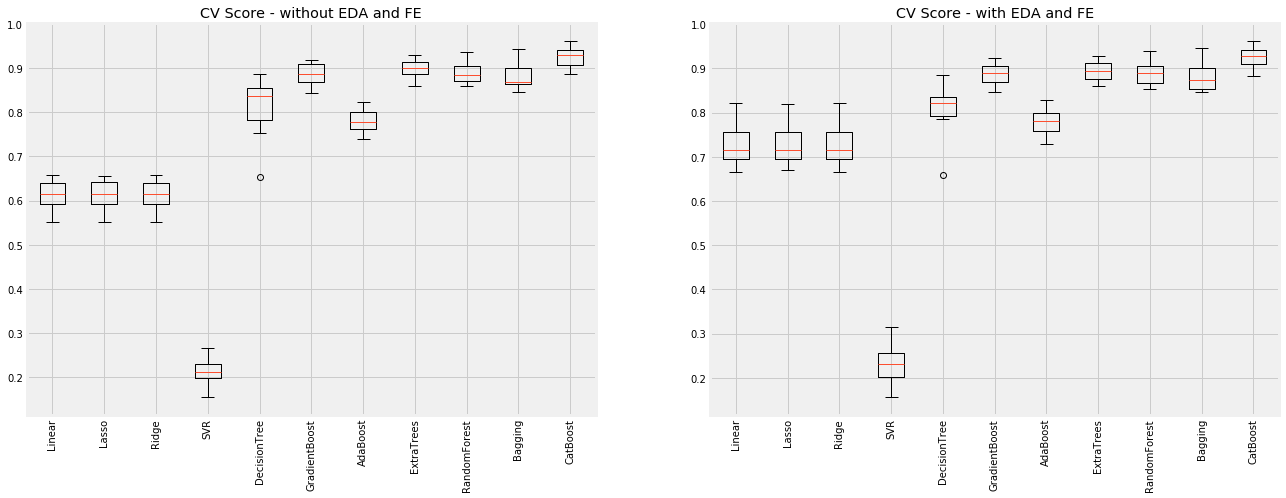

In [39]:
print('A significant improvement in r2 scores after EDA & FE for linear algorithms whereas remains almost same for tree-based algorithms.'); print('--'*60)

fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7.2))
ax1.boxplot(results['withoutedafe'][1]); ax1.set_xticklabels(results['withoutedafe'][0], rotation = 90); ax1.set_title('CV Score - without EDA and FE')
ax2.boxplot(results['withedafe'][1]); ax2.set_xticklabels(results['withedafe'][0], rotation = 90); ax2.set_title('CV Score - with EDA and FE')
plt.show()

Improvements are clearly seen for linear algorithms whereas for tree-based, it either marginally increases/decreases.
Tree-based algorithms are a clear choice when it comes to linear vs tree-based comparison.
CatboostRegressor gives us the highest R2 score.

# 3. Deliverable -3 (create the model )

# 3.a. Obtain feature importance for the individual features and present your findings

# Feature Importance

Checking if there exist any important feature interaction and make use of that to create features
Make use catboostregressor's feature interaction
------------------------------------------------------------------------------------------------------------------------
Feature Importance plot for catboostregressor using type = Interaction
Adding features based on cement and age; water and age can be useful
------------------------------------------------------------------------------------------------------------------------


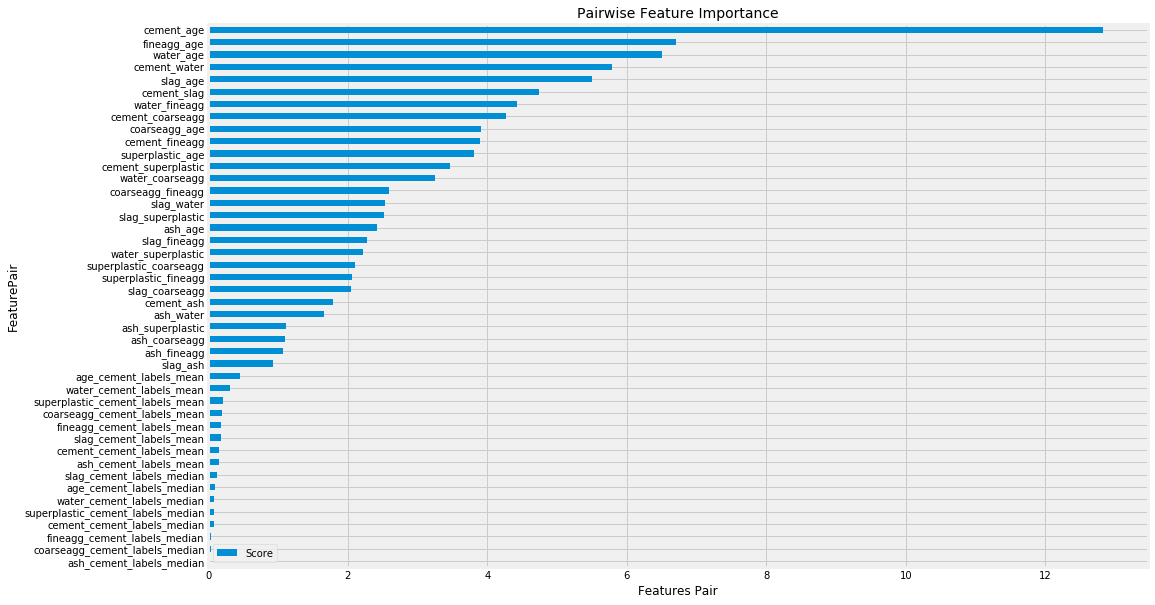

In [40]:
# Splitting the dataset into train and test set for checking feature interaction
print('Checking if there exist any important feature interaction and make use of that to create features')
print('Make use catboostregressor\'s feature interaction'); print('--'*60)

X = concrete_im.drop('strength', axis = 1)
y = concrete_im['strength']
features_list = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

# Initialize CatBoostRegressor
reg = CatBoostRegressor()
reg.fit(X_train, y_train, early_stopping_rounds = 5, verbose = False, eval_set = [(X_test, y_test)], use_best_model = True)
print('Feature Importance plot for catboostregressor using type = Interaction'); 
print('Adding features based on cement and age; water and age can be useful'); print('--'*60)
FI = reg.get_feature_importance(Pool(X_test, label = y_test), type = 'Interaction')
FI_new = []
for k, item in enumerate(FI):  
    first = X_test.dtypes.index[FI[k][0]]
    second = X_test.dtypes.index[FI[k][1]]
    if first != second:
        FI_new.append([first + "_" + second, FI[k][2]])
feature_score = pd.DataFrame(FI_new, columns = ['FeaturePair', 'Score'])
feature_score = feature_score.sort_values(by = 'Score', ascending = True)
ax = feature_score.plot('FeaturePair', 'Score', kind = 'barh', figsize = (15, 10))
ax.set_title('Pairwise Feature Importance', fontsize = 14)
ax.set_xlabel('Features Pair')
plt.show()


In [41]:
 #Adding features based on 'feature interaction'  catboostregressor
print('Adding features based on feature interaction we got from catboostregressor\'s feature importance'); print('--'*60)

cement_age = concrete_im.groupby('age', as_index = False)['cement'].agg(['mean', 'median'])
concrete_im = concrete_im.merge(cement_age, on = 'age', how = 'left')
concrete_im.rename(columns = {'mean': 'cement_age_mean', 'median': 'cement_age_median'}, inplace = True)

water_age = concrete_im.groupby('age')['water'].agg(['mean', 'median']); concrete_im = concrete_im.merge(water_age, on = 'age', how = 'left')
concrete_im.rename(columns = {'mean': 'water_age_mean', 'median': 'water_age_median'}, inplace = True)
concrete_im.describe()

Adding features based on feature interaction we got from catboostregressor's feature importance
------------------------------------------------------------------------------------------------------------------------


cement      slag       ash     water  superplastic  coarseagg  \
count 1030.0000 1030.0000 1030.0000 1030.0000     1030.0000  1030.0000   
mean   281.1679   73.3414   54.1883  181.6231        5.9717   972.9189   
std    104.5064   85.3545   63.9970   20.6008        5.4771    77.7540   
min    102.0000    0.0000    0.0000  126.6000        0.0000   801.0000   
25%    192.3750    0.0000    0.0000  164.9000        0.0000   932.0000   
50%    272.9000   22.0000    0.0000  185.0000        6.2047   968.0000   
75%    350.0000  142.7250  118.3000  192.0000       10.0750  1029.4000   
max    540.0000  342.1000  200.1000  228.0000       23.4000  1145.0000   

        fineagg       age  strength  cement_labels_mean  cement_labels_median  \
count 1030.0000 1030.0000 1030.0000           1030.0000             1030.0000   
mean   772.5173   33.2680   35.8180            281.1679              273.8802   
std     78.7018   27.9515   16.7057             86.5949               79.8961   
min    594.0000    1.0000    2.3300            203.2610              202.0000   
25%    730.9500    7.0000   23.7100            203.2610              202.0000   
50%    778.9000   28.0000   34.4450            203.2610              202.0000   
75%    822.2000   45.6621   46.1350            377.3262              362.6000   
max    945.0000  120.0000   82.6000            377.3262              362.6000   

       cement_age_mean  cement_age_median  water_age_mean  water_age_median  
count        1030.0000          1030.0000       1030.0000         1030.0000  
mean          281.1679           270.4381        181.6231          183.1264  
std            31.1742            34.9617         10.5005           13.7296  
min           220.9096           213.7500        157.7636          154.8000  
25%           265.4445           254.5000        176.6348          178.5000  
50%           265.4445           261.0000        182.6323          185.0000  
75%           294.1736           288.5000        182.6323          185.0000  
max           442.5000           442.5000        210.7966          228.0000

In [42]:
X = concrete_im.drop('strength', axis = 1)
y = concrete_im['strength']
features_list = list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

reg = CatBoostRegressor()
reg.fit(X_train, y_train, early_stopping_rounds = 5, verbose = False, eval_set = [(X_test, y_test)], use_best_model = True)

In [43]:
# Get feature importance -- eli5
perm = PermutationImportance(reg, random_state = random_state).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Feature Importance plot for catboostregressor using type = PredictionValuesChange
Age, cement and water are top 3 importance features
------------------------------------------------------------------------------------------------------------------------


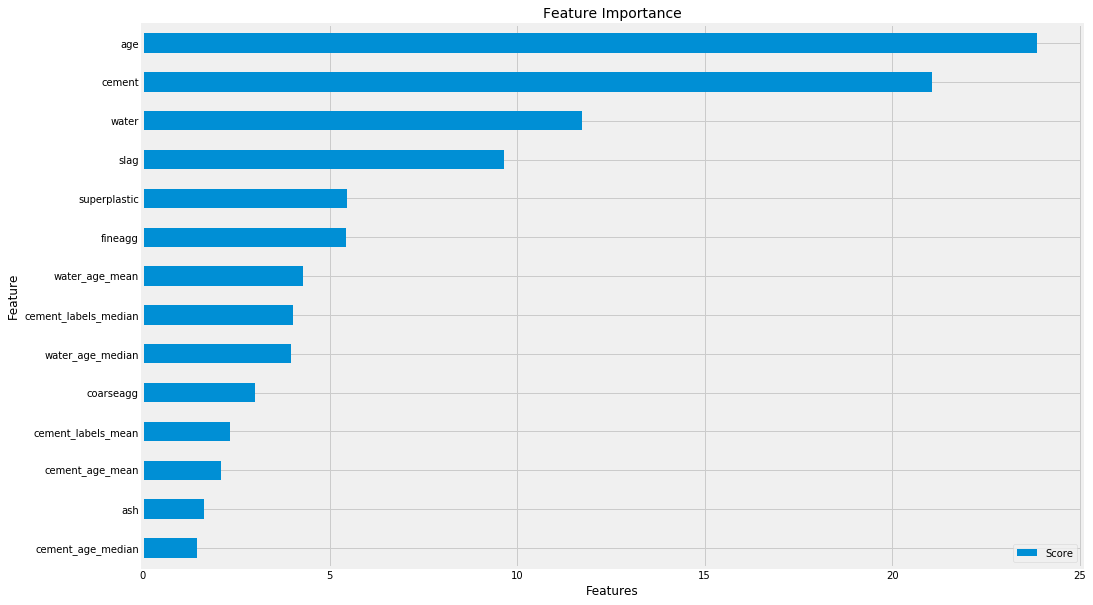

In [44]:
# Get feature importance -- model based
print('Feature Importance plot for catboostregressor using type = PredictionValuesChange'); 
print('Age, cement and water are top 3 importance features'); print('--'*60)
FI = reg.get_feature_importance(Pool(X_test, label = y_test), type = 'PredictionValuesChange')
feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, FI)), columns = ['Feature', 'Score'])
feature_score = feature_score.sort_values(by = 'Score', ascending = True)
ax = feature_score.plot('Feature', 'Score', kind = 'barh', figsize = (15, 10))
ax.set_title('Feature Importance', fontsize = 14)
ax.set_xlabel('Features')
plt.show()

water_age_median   water_age_mean      0.9541
water_age_mean     water_age_median    0.9541
cement_age_mean    cement_age_median   0.9084
cement_age_median  cement_age_mean     0.9084
dtype: float64

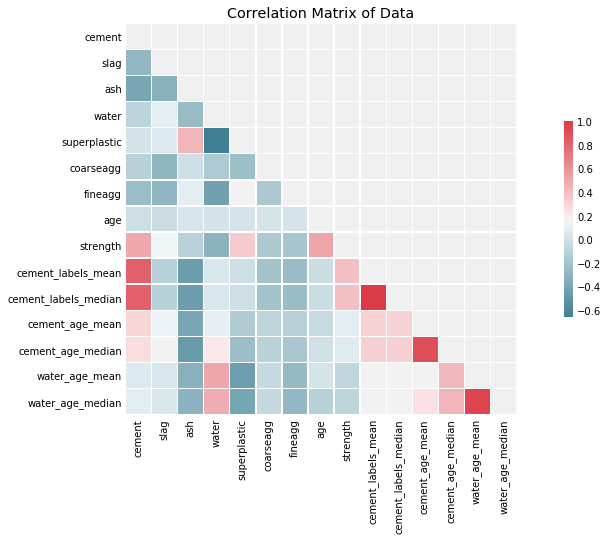

In [45]:
# Correlation matrix
correlation_matrix(concrete_im,threshold= 0.9)

In [46]:
# Absolute correlation of independent variables with the target variable
absCorrwithDep = []
allVars = concrete_im.drop('strength', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(concrete_im['strength'].corr(concrete_im[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

Variable Correlation
7                    age      0.5153
0                 cement      0.4978
9   cement_labels_median      0.4013
8     cement_labels_mean      0.4013
4           superplastic      0.3458
3                  water      0.3070
6                fineagg      0.1825
5              coarseagg      0.1649
1                   slag      0.1376
2                    ash      0.1058
13      water_age_median      0.0853
10       cement_age_mean      0.0758
11     cement_age_median      0.0720
12        water_age_mean      0.0716

In [47]:
print('A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, the regression coefficients are poorly estimated due to multicollinearity.')
print('--'*60)

y, X = dmatrices('strength ~ cement + slag + ash + water + superplastic + coarseagg + fineagg + age + cement_labels_mean + cement_labels_median + cement_age_mean + cement_age_median + water_age_mean + water_age_median', 
                 concrete_im, return_type = 'dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
display(vif.round(1).sort_values(by = 'VIF Factor', ascending = False))

A VIF between 5 and 10 indicates high correlation that may be problematic. And if the VIF goes above 10, the regression coefficients are poorly estimated due to multicollinearity.
------------------------------------------------------------------------------------------------------------------------


VIF Factor              Features
9          inf    cement_labels_mean
10         inf  cement_labels_median
13     15.8000        water_age_mean
14     14.9000      water_age_median
12      9.3000     cement_age_median
1       8.1000                cement
11      7.9000       cement_age_mean
2       5.9000                  slag
4       5.5000                 water
7       5.5000               fineagg
3       5.4000                   ash
6       3.9000             coarseagg
5       3.2000          superplastic
8       1.3000                   age
0       0.0000             Intercept

In [48]:
concrete_im.drop(['water_age_mean', 'water_age_median', 'cement_age_mean', 'cement_labels_mean', 'cement_labels_median', 'cement_age_mean'], axis = 1, inplace = True)
concrete_im.shape, concrete_im.columns

((1030, 10),
 Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
        'fineagg', 'age', 'strength', 'cement_age_median'],
       dtype='object'))

CatBoostRegressor's feature interaction to add features based on cement and age; water and age interaction.

In this step, we added 6 new features. While performing the Feature Importance process ,age, cement, water, slag are some of the importance features based on eli5 and model based feature importance. 

Dropping all newly added features since they resulted in multicollinearity

In [166]:
#Check whether Dataset is scaled or Non-scaled 

In [49]:
scalers = {'notscaled': None, 'standardscaling': StandardScaler(), 'robustscaling': RobustScaler()}

training_test_sets = {'validation_sets': (X_train_fe, y_train_fe, X_val_fe, y_val_fe),
                      'test_sets': (X_train_fe, y_train_fe, X_test_fe, y_test_fe)}

# initialize model
cat_reg = CatBoostRegressor()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_val, _y_val) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        scores = []
        if scaler == None:
          trainingset = _X_train.copy()
          testset = _X_val.copy()
          cat_reg.fit(trainingset, _y_train, early_stopping_rounds = 5, verbose = False, plot = False,
                      eval_set = [(testset, _y_val)], use_best_model = True)
          pred = cat_reg.predict(testset)
          rmse = rmse_score(_y_val, pred)
          r2 = r2_score(_y_val, pred)
          scores.append([rmse, r2])
          key = encoding_label + ' - ' + scaler_label
          errors[key] = scores[0]
        else:
          trainingset = _X_train.copy()
          testset = _X_val.copy()
          trainingset = scaler.fit_transform(trainingset)
          testset = scaler.transform(testset)
          cat_reg.fit(trainingset, _y_train, early_stopping_rounds = 5, verbose = False, plot = False,
                      eval_set = [(testset, _y_val)], use_best_model = True)
          pred = cat_reg.predict(testset)
          rmse = rmse_score(_y_val, pred)
          r2 = r2_score(_y_val, pred)
          scores.append([rmse, r2])
          key = encoding_label + ' - ' + scaler_label
          errors[key] = scores[0]

In [50]:
print('RMSE is lowest when robust scaling is used whereas R2 almost remains same as un-scaled data.'); 
print('Scaling effectively use the training and validation Data sets .');print('--'*60)

display(errors)

RMSE is lowest when robust scaling is used whereas R2 almost remains same as un-scaled data.
Scaling effectively use the training and validation Data sets .
------------------------------------------------------------------------------------------------------------------------


{'validation_sets - notscaled': [5.299929421350343, 0.9071266574705928],
 'validation_sets - standardscaling': [5.300729056169528, 0.9070986305460964],
 'validation_sets - robustscaling': [5.300608919536106, 0.9071028415635518],
 'test_sets - notscaled': [3.6247764389132655, 0.9513313907774652],
 'test_sets - standardscaling': [3.6252638459699993, 0.9513183014083237],
 'test_sets - robustscaling': [3.625955503644987, 0.9512997238460194]}

In [51]:
## Helper function to train, validate and predict Data
def train_val_predict(basemodel, train_X, train_y, test_X, test_y, name, model):

  folds = list(KFold(n_splits = 5, random_state = random_state, shuffle = True).split(train_X, train_y))
  
  r2_scores_train = []; r2_scores_val = []; r2_scores_test = []

  for j, (train_index, val_index) in enumerate(folds):
    X_train = train_X.iloc[train_index]
    y_train = train_y.iloc[train_index]
    X_val = train_X.iloc[val_index]
    y_val = train_y.iloc[val_index]

    if model == 'CatBoost':
      basemodel.fit(X_train, y_train, early_stopping_rounds = 5, verbose = 300, eval_set = [(X_val, y_val)], use_best_model = True)
    else:
      basemodel.fit(X_train, y_train)

    pred = basemodel.predict(X_train)
    r2 = r2_score(y_train, pred); r2_scores_train.append(r2)
    
    pred = basemodel.predict(X_val)
    r2 = r2_score(y_val, pred); r2_scores_val.append(r2)

    pred = basemodel.predict(X_test_fe)
    r2 = r2_score(y_test_fe, pred); r2_scores_test.append(r2)

  df = pd.DataFrame([np.mean(r2_scores_train), np.mean(r2_scores_val), np.mean(r2_scores_test)],
                    index = ['r2 Scores Train', 'r2 Scores Val', 'r2 Scores Test'], 
                    columns = [name]).T
  return df

In [52]:
print('Separating the dependents and independents features and  Scaling the data'); print('--'*60)
features_list = list(concrete_im.columns)
concrete_im = concrete_im.apply(zscore); concrete_im = pd.DataFrame(concrete_im , columns = features_list)
display(concrete_im.describe())

X = concrete_im.drop('strength', axis = 1); y = concrete_im['strength']; 
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X, y, test_size = 0.2, random_state = random_state)

print('Dimension of the Independent Features Train and test set',X_train_fe.shape ,X_test_fe.shape)
print ('Dimension of the Target attribute train and Test set' ,y_train_fe.shape, y_test_fe.shape)

Separating the dependents and independents features and  Scaling the data
------------------------------------------------------------------------------------------------------------------------


cement      slag       ash     water  superplastic  coarseagg  \
count 1030.0000 1030.0000 1030.0000 1030.0000     1030.0000  1030.0000   
mean    -0.0000    0.0000    0.0000    0.0000        0.0000     0.0000   
std      1.0005    1.0005    1.0005    1.0005        1.0005     1.0005   
min     -1.7153   -0.8597   -0.8471   -2.6722       -1.0908    -2.2121   
25%     -0.8501   -0.8597   -0.8471   -0.8122       -1.0908    -0.5265   
50%     -0.0792   -0.6018   -0.8471    0.1640        0.0426    -0.0633   
75%      0.6590    0.8133    1.0023    0.5040        0.7495     0.7268   
max      2.4779    3.1503    2.2811    2.2523        3.1836     2.2142   

        fineagg       age  strength  cement_age_median  
count 1030.0000 1030.0000 1030.0000          1030.0000  
mean    -0.0000    0.0000   -0.0000            -0.0000  
std      1.0005    1.0005    1.0005             1.0005  
min     -2.2694   -1.1550   -2.0056            -1.6222  
25%     -0.5284   -0.9402   -0.7251            -0.4561  
50%      0.0811   -0.1886   -0.0822            -0.2701  
75%      0.6316    0.4436    0.6179             0.5169  
max      2.1927    3.1045    2.8017             4.9238

Dimension of the Independent Features Train and test set (824, 9) (206, 9)
Dimension of the Target attribute train and Test set (824,) (206,)


# 4. Deliverable -4 (Tuning the model) 

# 4.a. Algorithms that you think will be suitable for this project and 4.b. Techniques employed to squeeze that extra performance out of the model without making it overfit or underfit

# Model Building and Perform HyperParamter Tuning without making Model overfit or underfit

# Linear Regression, Lasso , Ridge

In [53]:
print('Using the 5-Fold Linear Regression to train, validate and predict'); print('--'*60)
lr_reg = LinearRegression()
df_lr = train_val_predict(lr_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold LinearRegression', model = 'LR')

Using the 5-Fold Linear Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


In [54]:
print('Using the 5-Fold Lasso Regression to train, validate and predict'); print('--'*60)
lasso_reg = Lasso(alpha = 0.01)
df_lasso = train_val_predict(lasso_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold LassoRegression', model = 'Lasso')
df = df_lr.append(df_lasso)
df

Using the 5-Fold Lasso Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  r2 Scores Test
5-Fold LinearRegression           0.7355         0.7244          0.7730
5-Fold LassoRegression            0.7341         0.7241          0.7712

In [55]:
print('Using the 5-Fold Ridge Regression to train, validate and predict'); print('--'*60)
ridge_reg = Ridge(alpha = 0.01)
df_ridge = train_val_predict(ridge_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RidgeRegression', model = 'Ridge')
df = df.append(df_ridge)
df

Using the 5-Fold Ridge Regression to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  r2 Scores Test
5-Fold LinearRegression           0.7355         0.7244          0.7730
5-Fold LassoRegression            0.7341         0.7241          0.7712
5-Fold RidgeRegression            0.7355         0.7244          0.7730

# Decision Tree and Random Forest

In [56]:
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict'); print('--'*60)
dt_reg = DecisionTreeRegressor(random_state = random_state)
df_reg = train_val_predict(dt_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree', model = 'DT')
df = df.append(df_reg)
df

Using the 5-Fold Decision Tree Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  r2 Scores Test
5-Fold LinearRegression           0.7355         0.7244          0.7730
5-Fold LassoRegression            0.7341         0.7241          0.7712
5-Fold RidgeRegression            0.7355         0.7244          0.7730
5-Fold DecisionTree               0.9952         0.7856          0.8434

In [57]:
# HyperParameter tuning Decision Tree and Random Forest Model using GridSearchCV 
print('Finding out the hyperparameters for Decision Tree and Random Forest with GridSearchCV'); print('--'*60)
best_params_grid = {}

# Decision Tree and Random Forest Regressor Hyperparameters Grid
param_grid = {'DecisionTree': {'criterion': ['mse', 'mae'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
              'RandomForest': {'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                                'max_features': ['auto', 'sqrt'], 'n_estimators': [200, 400, 600, 800]}}

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state = random_state)
dt_reg_grid = GridSearchCV(dt_reg, param_grid['DecisionTree'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
dt_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['DecisionTree'] = dt_reg_grid.best_params_

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = random_state)
rf_reg_grid = GridSearchCV(rf_reg, param_grid['RandomForest'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
rf_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['RandomForest'] = rf_reg_grid.best_params_

print(f'Best parameters for Decision Tree and Random Forest using GridSearchCV: {best_params_grid}')

Finding out the hyperparameters for Decision Tree and Random Forest with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Decision Tree and Random Forest using GridSearchCV: {'DecisionTree': {'criterion': 'mse', 'max_depth': None}, 'RandomForest': {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}}


In [58]:
#HyperParameter tuning Decision Tree and Random Forest Model using RandomizedSearchCV
print('Finding out the hyperparameters for Decision Tree and Random Forest with RandomizedSearchCV'); print('--'*60)
best_params_random = {}

# Decision Tree and Random Forest Regressor Hyperparameters Grid
param_grid = {'DecisionTree': {'criterion': ['mse', 'mae'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None]},
              'RandomForest': {'bootstrap': [True, False], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                                'max_features': ['auto', 'sqrt'], 'n_estimators': [200, 400, 600, 800]}}

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state = random_state)
dt_reg_grid = RandomizedSearchCV(dt_reg, param_grid['DecisionTree'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
dt_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['DecisionTree'] = dt_reg_grid.best_params_

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state = random_state)
rf_reg_grid = RandomizedSearchCV(rf_reg, param_grid['RandomForest'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
rf_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['RandomForest'] = rf_reg_grid.best_params_

print(f'Best parameters for Decision Tree and Random Forest using RandomizedSearchCV: {best_params_random}')

Finding out the hyperparameters for Decision Tree and Random Forest with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Decision Tree and Random Forest using RandomizedSearchCV: {'DecisionTree': {'max_depth': None, 'criterion': 'mae'}, 'RandomForest': {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': False}}


In [59]:
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
dt_reg_grid = DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree'])
df_reg_grid = train_val_predict(dt_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree GridSearchCV', model = 'DT')
df = df.append(df_reg_grid)

Using the 5-Fold Decision Tree Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------


In [60]:
print('Using the 5-Fold Decision Tree Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
dt_reg_rand = DecisionTreeRegressor(random_state = random_state, **best_params_random['DecisionTree'])
df_reg_rand = train_val_predict(dt_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold DecisionTree RandomizedSearchCV', model = 'DT')
df = df.append(df_reg_rand)
display(df)

Using the 5-Fold Decision Tree Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                          0.7355         0.7244   
5-Fold LassoRegression                           0.7341         0.7241   
5-Fold RidgeRegression                           0.7355         0.7244   
5-Fold DecisionTree                              0.9952         0.7856   
5-Fold DecisionTree GridSearchCV                 0.9952         0.7856   
5-Fold DecisionTree RandomizedSearchCV           0.9937         0.8056   

                                        r2 Scores Test  
5-Fold LinearRegression                         0.7730  
5-Fold LassoRegression                          0.7712  
5-Fold RidgeRegression                          0.7730  
5-Fold DecisionTree                             0.8434  
5-Fold DecisionTree GridSearchCV                0.8434  
5-Fold DecisionTree RandomizedSearchCV          0.8550

In [61]:
print('Using the 5-Fold Random Forest Regressor to train, validate and predict'); print('--'*60)
rf_reg = RandomForestRegressor(random_state = random_state)
df_reg = train_val_predict(rf_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest', model = 'RF')
df = df.append(df_reg)

Using the 5-Fold Random Forest Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


In [62]:
print('Using the 5-Fold Random Forest Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
rf_reg_grid = RandomForestRegressor(random_state = random_state, **best_params_grid['RandomForest'])
df_reg_grid = train_val_predict(rf_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest GridSearchCV', model = 'RF')
df = df.append(df_reg_grid)

Using the 5-Fold Random Forest Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------


In [63]:
print('Using the 5-Fold Random Forest Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
rf_reg_rand = RandomForestRegressor(random_state = random_state, **best_params_random['RandomForest'])
df_reg_rand = train_val_predict(rf_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold RandomForest RandomizedSearchCV', model = 'RF')
df = df.append(df_reg_rand)

Using the 5-Fold Random Forest Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


In [64]:
#Display Dataframe of all desired Models
df

r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                          0.7355         0.7244   
5-Fold LassoRegression                           0.7341         0.7241   
5-Fold RidgeRegression                           0.7355         0.7244   
5-Fold DecisionTree                              0.9952         0.7856   
5-Fold DecisionTree GridSearchCV                 0.9952         0.7856   
5-Fold DecisionTree RandomizedSearchCV           0.9937         0.8056   
5-Fold RandomForest                              0.9816         0.8884   
5-Fold RandomForest GridSearchCV                 0.9952         0.8937   
5-Fold RandomForest RandomizedSearchCV           0.9623         0.8712   

                                        r2 Scores Test  
5-Fold LinearRegression                         0.7730  
5-Fold LassoRegression                          0.7712  
5-Fold RidgeRegression                          0.7730  
5-Fold DecisionTree                             0.8434  
5-Fold DecisionTree GridSearchCV                0.8434  
5-Fold DecisionTree RandomizedSearchCV          0.8550  
5-Fold RandomForest                             0.9248  
5-Fold RandomForest GridSearchCV                0.9299  
5-Fold RandomForest RandomizedSearchCV          0.8984

# AdaBoost and GradientBoost

In [65]:
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict'); print('--'*60)
ada_reg = AdaBoostRegressor(random_state = random_state)
df_reg = train_val_predict(ada_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost', model = 'Ada')
df = df.append(df_reg)

Using the 5-Fold Ada Boost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


In [66]:
#Hyper Parameter tuning AdaBoost Model with GridSearchCV
print('Finding out the hyperparameters for AdaBoostRegressor with GridSearchCV'); print('--'*60)

param_grid = {'AdaBoost': {'base_estimator': [DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree']), None],
                           'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.1, 1.0]}}

# AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state = random_state)
ada_reg_grid = GridSearchCV(ada_reg, param_grid['AdaBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
ada_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['AdaBoost'] = ada_reg_grid.best_params_

print('Best parameters for AdaBoost Regressor using GridSearchCV: {}'.format(best_params_grid['AdaBoost']))

Finding out the hyperparameters for AdaBoostRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for AdaBoost Regressor using GridSearchCV: {'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2020, splitter='best'), 'learning_rate': 0.1, 'n_estimators': 200}


In [67]:
#HyperParameter tuning AdaBoost Model with RandomizedSearchCV
print('Finding out the hyperparameters for AdaBoostRegressor with RandomizedSearchCV'); print('--'*60)

param_grid = {'AdaBoost': {'base_estimator': [DecisionTreeRegressor(random_state = random_state, **best_params_grid['DecisionTree']), None],
                           'n_estimators': [100, 150, 200], 'learning_rate': [0.01, 0.1, 1.0]}}

# AdaBoost Regressor
ada_reg = AdaBoostRegressor(random_state = random_state)
ada_reg_grid = RandomizedSearchCV(ada_reg, param_grid['AdaBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
ada_reg_grid.fit(X_train_fe, y_train_fe)
best_params_random['AdaBoost'] = ada_reg_grid.best_params_

print('Best parameters for AdaBoost Regressor using RandomizedSearchCV: {}'.format(best_params_random['AdaBoost']))

Finding out the hyperparameters for AdaBoostRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for AdaBoost Regressor using RandomizedSearchCV: {'n_estimators': 200, 'learning_rate': 0.1, 'base_estimator': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=2020, splitter='best')}


In [68]:
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
ada_reg_grid = AdaBoostRegressor(random_state = random_state, **best_params_grid['AdaBoost'])
df_reg_grid = train_val_predict(ada_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost using GridSearchCV', model = 'Ada')
df = df.append(df_reg_grid)

Using the 5-Fold Ada Boost Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------


In [69]:
print('Using the 5-Fold Ada Boost Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
ada_reg_rand = AdaBoostRegressor(random_state = random_state, **best_params_random['AdaBoost'])
df_reg_rand = train_val_predict(ada_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold AdaBoost using RandomizedSearchCV', model = 'Ada')
df = df.append(df_reg_rand)
df

Using the 5-Fold Ada Boost Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                            0.7355         0.7244   
5-Fold LassoRegression                             0.7341         0.7241   
5-Fold RidgeRegression                             0.7355         0.7244   
5-Fold DecisionTree                                0.9952         0.7856   
5-Fold DecisionTree GridSearchCV                   0.9952         0.7856   
5-Fold DecisionTree RandomizedSearchCV             0.9937         0.8056   
5-Fold RandomForest                                0.9816         0.8884   
5-Fold RandomForest GridSearchCV                   0.9952         0.8937   
5-Fold RandomForest RandomizedSearchCV             0.9623         0.8712   
5-Fold AdaBoost                                    0.8153         0.7725   
5-Fold AdaBoost using GridSearchCV                 0.9934         0.8808   
5-Fold AdaBoost using RandomizedSearchCV           0.9934         0.8808   

                                          r2 Scores Test  
5-Fold LinearRegression                           0.7730  
5-Fold LassoRegression                            0.7712  
5-Fold RidgeRegression                            0.7730  
5-Fold DecisionTree                               0.8434  
5-Fold DecisionTree GridSearchCV                  0.8434  
5-Fold DecisionTree RandomizedSearchCV            0.8550  
5-Fold RandomForest                               0.9248  
5-Fold RandomForest GridSearchCV                  0.9299  
5-Fold RandomForest RandomizedSearchCV            0.8984  
5-Fold AdaBoost                                   0.8029  
5-Fold AdaBoost using GridSearchCV                0.9200  
5-Fold AdaBoost using RandomizedSearchCV          0.9200

In [70]:
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict'); print('--'*60)
gb_reg = GradientBoostingRegressor(random_state = random_state)
df_reg = train_val_predict(gb_reg, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost', model = 'GB')
df = df.append(df_reg)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict
------------------------------------------------------------------------------------------------------------------------


In [71]:
#HyperParameter Tuning GradientBoost Model using GridSearchCV
print('Finding out the hyperparameters for GradientBoostRegressor with GridSearchCV'); print('--'*60)

param_grid = {'GradientBoost': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [600, 800, 1000]}}

# GradientBoostRegressor
gb_reg = GradientBoostingRegressor(random_state = random_state)
gb_reg_grid = GridSearchCV(gb_reg, param_grid['GradientBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
gb_reg_grid.fit(X_train_fe, y_train_fe)
best_params_grid['GradientBoost'] = gb_reg_grid.best_params_

print('Best parameters for Gradient Boost Regressor using GridSearchCV: {}'.format(best_params_grid['GradientBoost']))

Finding out the hyperparameters for GradientBoostRegressor with GridSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Gradient Boost Regressor using GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 600}


In [72]:
#HyperParameter Tuning GradientBoost Model using RandomizedSearchCV
print('Finding out the hyperparameters for GradientBoostRegressor with RandomizedSearchCV'); print('--'*60)

param_grid = {'GradientBoost': {'max_depth': [5, 6, 7, 8, 9, 10, None], 'max_features': ['auto', 'sqrt'], 
                                'n_estimators': [600, 800, 1000]}}

# GradientBoostRegressor
gb_reg = GradientBoostingRegressor(random_state = random_state)
gb_reg_rand = RandomizedSearchCV(gb_reg, param_grid['GradientBoost'], cv = 5, n_jobs = -1, verbose = False, scoring = 'r2')
gb_reg_rand.fit(X_train_fe, y_train_fe)
best_params_random['GradientBoost'] = gb_reg_rand.best_params_

print('Best parameters for Gradient Boost Regressor using RandomizedSearchCV: {}'.format(best_params_random['GradientBoost']))

Finding out the hyperparameters for GradientBoostRegressor with RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------
Best parameters for Gradient Boost Regressor using RandomizedSearchCV: {'n_estimators': 600, 'max_features': 'sqrt', 'max_depth': 5}


In [73]:
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict using GridSearchCV'); print('--'*60)
gb_reg_grid = GradientBoostingRegressor(random_state = random_state, **best_params_grid['GradientBoost'])
df_reg_grid = train_val_predict(gb_reg_grid, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost using GridSearchCV', model = 'GB')
df = df.append(df_reg_grid)

Using the 5-Fold Gradient Boost Regressor to train, validate and predict using GridSearchCV
------------------------------------------------------------------------------------------------------------------------


In [74]:
print('Using the 5-Fold Gradient Boost Regressor to train, validate and predict using RandomizedSearchCV'); print('--'*60)
gb_reg_rand = GradientBoostingRegressor(random_state = random_state, **best_params_random['GradientBoost'])
df_reg_rand = train_val_predict(gb_reg_rand, X_train_fe, y_train_fe, X_test_fe, y_test_fe, '5-Fold GradientBoost using RandomizedSearchCV', model = 'GB')
df = df.append(df_reg_rand)
df

Using the 5-Fold Gradient Boost Regressor to train, validate and predict using RandomizedSearchCV
------------------------------------------------------------------------------------------------------------------------


r2 Scores Train  r2 Scores Val  \
5-Fold LinearRegression                                 0.7355         0.7244   
5-Fold LassoRegression                                  0.7341         0.7241   
5-Fold RidgeRegression                                  0.7355         0.7244   
5-Fold DecisionTree                                     0.9952         0.7856   
5-Fold DecisionTree GridSearchCV                        0.9952         0.7856   
5-Fold DecisionTree RandomizedSearchCV                  0.9937         0.8056   
5-Fold RandomForest                                     0.9816         0.8884   
5-Fold RandomForest GridSearchCV                        0.9952         0.8937   
5-Fold RandomForest RandomizedSearchCV                  0.9623         0.8712   
5-Fold AdaBoost                                         0.8153         0.7725   
5-Fold AdaBoost using GridSearchCV                      0.9934         0.8808   
5-Fold AdaBoost using RandomizedSearchCV                0.9934         0.8808   
5-Fold GradientBoost                                    0.9502         0.8905   
5-Fold GradientBoost using GridSearchCV                 0.9951         0.9172   
5-Fold GradientBoost using RandomizedSearchCV           0.9951         0.9172   

                                               r2 Scores Test  
5-Fold LinearRegression                                0.7730  
5-Fold LassoRegression                                 0.7712  
5-Fold RidgeRegression                                 0.7730  
5-Fold DecisionTree                                    0.8434  
5-Fold DecisionTree GridSearchCV                       0.8434  
5-Fold DecisionTree RandomizedSearchCV                 0.8550  
5-Fold RandomForest                                    0.9248  
5-Fold RandomForest GridSearchCV                       0.9299  
5-Fold RandomForest RandomizedSearchCV                 0.8984  
5-Fold AdaBoost                                        0.8029  
5-Fold AdaBoost using GridSearchCV                     0.9200  
5-Fold AdaBoost using RandomizedSearchCV               0.9200  
5-Fold GradientBoost                                   0.9074  
5-Fold GradientBoost using GridSearchCV                0.9438  
5-Fold GradientBoost using RandomizedSearchCV          0.9438

Gradient Boost Regression turned out to be the Best Model when used with 5-fold cross validation and Grid/Randomized SearchCV with R2 score for training, validation and test as 0.999, 0.931 and 0.899 respectively

# 4.c. Model performance range at 95% confidence level

In [83]:
values = concrete_im.values
n_iterations = 100 # Number of bootstrap samples
n_size = int(len(concrete_im) * 1) # size of a bootstrap sample

# run bootstrapping
stats = list() # empty list that will hold the scores for each bootstrap iteration
for i in range(n_iterations):
  # prepare train and test sets
  train = resample(values, n_samples = n_size) # Sampling with replacement 
  test = np.array([x for x in values if x.tolist() not in train.tolist()]) # picking rest of the data not considered in sample
  
  # fit model
  gb_reg_grid = GradientBoostingRegressor(random_state = random_state, **best_params_grid['GradientBoost'])
  gb_reg_grid.fit(train[:, :-1], train[:, -1]) # fit against independent variables and corresponding target values

  # evaluate model
  predictions = gb_reg_grid.predict(test[:, :-1]) # predict based on independent variables in the test data
  score = r2_score(test[:, -1], predictions)
  stats.append(score)


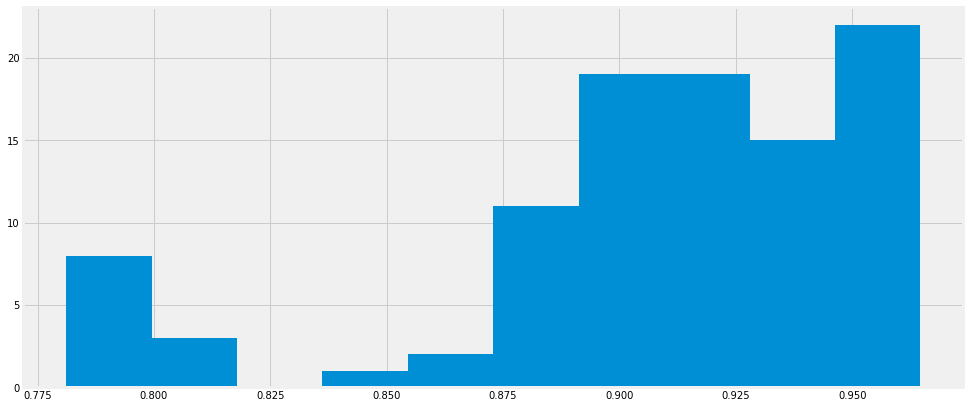

95.0 confidence interval 78.6% and 96.3%


In [85]:
plt.figure(figsize = (15, 7))
plt.hist(stats);
plt.show()
# Confidence interval
alpha = 0.95 # for 95% confidence level
p = ((1.0 - alpha) / 2.0) * 100 # tail regions on right and left .25 on each side indicated by P value (border)
lower = max(0.0, np.percentile(stats, p))  

p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(stats, p))

print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

# CONCLUSION

In the EDA stage ,explored to view IQR, Kurtosis, Skewness and other statistics.

Performed further descriptive statistics to explore missing values and outliers.Checked the relationship between independent and dependent variables and seen that Relationship between Cement and Strength is linear.
Employed BoxPlot Analysis, IQR method, studentized residual, leverage to analyze outliers and address presence of leverage points.

In the feature engineering Step, Identified opportunities to add features based on Feature interaction and gaussians (Cluster Analysis)but end up adding multicollinearity in the data.

Model based feature importance, eli5, correlation matrix, absolute correlation and variance inflation factor to understand Most important attributes which are age, cement, water and Slag.

Used cross validation method to compare linear and non-linear/tree-based models on training and validation sets. R2 Scores found as Imporatant evaluation Metrics after performing exploratory data analysis and feature engineering steps.

Created  3 Linear regressions (Linear, Lasso and Ridge) and Decision tree-based regression methods such as Decision Tree, Random Forest, AdaBoost, Gradient Boost. 
Employed k-Fold cross validation, Grid SearchCV and RandomizedSearchCV methods to squeeze out the extra performance out of the model without making it overfit or underfit.

Gradient Boost Regression turned out to be the Best Model when used with 5-fold cross validation and Grid/Randomized SearchCV with R2 score for training, validation and test as 0.999, 0.931 and 0.899 respectively. 

Use Bootstrapping method to calculate confidence intervals for Gradient Boost Regressor as this is the Best among other models.At 95% Confidence Interval , R2 score lies between 76.5% and 96.1% for Gradient Boost Regressor.
